# **SIADS Milestone II - Forecasting Federal Funds Rate Movements through Natural Language Processing of FOMC Minutes**

**s24-milestone2-team7-cspaarg-cydia-davidrez**
- **Casey Spaargaren(cspaarg@umich.edu)**, School of Information, University of Michigan
- **Cydia Tsang (cydia@umich.edu)**, School of Information, University of Michigan
- **David Rezkalla(davidrez@umich.edu)**, School of Information, University of Michigan


#### **Strcuture of the Code:**
&emsp; **Prerequisite**<br>
&emsp;&emsp;&emsp; 1.Library Download & Import<br>
&emsp;&emsp;&emsp; 2.Hugging Face Login<br>
&emsp; **A Data Import**<br>
&emsp;&emsp;&emsp; Federal Reserve's meeting minutes from 1993 to 2024<br>
&emsp; **B. Data Cleaning & Manipulation**<br>
&emsp;&emsp;&emsp; 1.Data Cleaning<br>
&emsp;&emsp;&emsp; 2.Data Manipulation on Meeting Minutes<br>
&emsp;&emsp;&emsp; 3.Data Manipulation on Federal Funds Rate<br>
&emsp;&emsp;&emsp; 4. Data Merge Between MeetingMinutes & Federa Funds Rate<br>
&emsp; **C. Basic NLP Analysis**<br>
&emsp;&emsp;&emsp; 1. Sentiment analysis<br>
&emsp;&emsp;&emsp; 2. Key phrase extraction<br>
&emsp; **D. Supervising Learning**<br>
&emsp;&emsp;&emsp; 1. Base Model - Linear Regression<br>
&emsp;&emsp;&emsp; 2. Actual Model - Linear Regression, Support Vector Machine, Decision Tree Regressor and XGBoost Regressor<br>
&emsp;&emsp;&emsp; 3. Actual Model With Temporal Features<br>
&emsp;&emsp;&emsp; 4. Actual Model With Sentiment Analysis<br>
&emsp; **E. Unsupervising Learning**<br>
&emsp;&emsp;&emsp; 1. KMeans Clustering<br>
&emsp;&emsp;&emsp; 2. LDA Topic grouping<br>
&emsp;&emsp;&emsp; 3. Semantic Analysis<br>
&emsp;&emsp;&emsp; 4. LSTM (Long Short-Term Memory) Networks:<br>
&emsp;&emsp;&emsp; 5. Principal Component Analysis (PCA)<br>

# **Prerequisite**
#### **1. Library Download & Import**

In [1]:
#Remeber to run the following commannd before running the following codes. Details Please refer to README.md
#!pip install -r requirements.txt
#!python -m spacy download en_core_web_sm

In [2]:
from bs4 import BeautifulSoup
import urllib
from time import sleep
import re
import csv
import os
from os import listdir
from os.path import isfile, join
import glob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import pandas as pd
import numpy as np
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from collections import Counter
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob
import gensim
from gensim.models import CoherenceModel
import gensim.corpora as corpora
from xgboost import XGBRegressor
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForCausalLM, AutoModelForSeq2SeqLM
from transformers import BertTokenizer, BertForSequenceClassification, BartForConditionalGeneration
from transformers import pipeline
from cryptography.fernet import Fernet
import huggingface_hub
import warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# NLTK downloads
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Configure pandas
pd.set_option('display.max_columns', None)

# Ignore warnings
warnings.filterwarnings("ignore")

# Set device for torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#### **2. Hugging Face Login**
This code securely retrieves and uses a Hugging Face token by first reading a secret key from a file named "key.txt." It then uses this key to create a decryption tool, which unlocks the encrypted Hugging Face token stored in another file called "hf_token.txt." Once the token is decrypted and readable, the code uses it to log into the Hugging Face service, ensuring that the sensitive token is handled safely and not exposed directly in the code.

In [3]:
def get_hf_token():
    with open("key.txt", "rb") as file:
        key = file.read()
    cipher_suite = Fernet(key)
    with open("hf_token.txt", "rb") as file:
        encrypted_token = file.read()
    decrypted_token = cipher_suite.decrypt(encrypted_token).decode()
    return decrypted_token

hf_token = get_hf_token()
huggingface_hub.login(token=hf_token)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /Users/cydiatsang/.cache/huggingface/token
Login successful


# **A. Data Import**

The project requires the Federal Reserve's meeting minutes from 1993 to 2024, sourced from the official Fed website at https://www.federalreserve.gov. The Federal Open Market Committee (FOMC) holds eight regularly scheduled meetings each year, with additional meetings as needed. Policy statements and minutes are linked in the calendars on the website. The minutes of regularly scheduled meetings are released three weeks after the policy decision date, and committee membership changes occur at the first meeting of each year. The retrieved data is organized and stored as individual files, named meeting_minute_YYYYMMDD.txt, in the data/output directory.

In [4]:
releaseDates = [line.rstrip() for line in open(os.path.join('data/meeting_minute/meeting_dates.csv'), 'r')]

def getFedMeetingMinutesUrl(date):
    year = date[0:4]
    dateInt = int(date)
    if dateInt <= 19951219:
        url = 'https://www.federalreserve.gov/fomc/MINUTES/' + year + '/' + date + 'min.htm'
    elif dateInt >= 19950201 and dateInt < 20070918:
        url = 'https://www.federalreserve.gov/fomc/minutes/' + date + '.htm'
    elif dateInt == 20080625:
        url = 'https://www.federalreserve.gov/monetarypolicy/fomc20080625.htm'
    elif dateInt > 20070918:
        url = 'https://www.federalreserve.gov/monetarypolicy/fomcminutes' + date + '.htm'
    print(url)
    return url

def getStatement(date):
    print('Pulling meeting minute of date: ' + date)
    req = urllib.request.Request(getFedMeetingMinutesUrl(date), headers={'User-Agent' : "Magic Browser"}) 
    html = urllib.request.urlopen(req).read()
    soup = BeautifulSoup(html)
    minutesText = soup.get_text(" ")
    return minutesText

In [5]:
for releaseDate in releaseDates:
    file_path="./data/output/meeting_minute_" + releaseDate +".txt"
    if os.path.isfile(file_path) == False:
        data = getStatement(releaseDate)
        sleep(2)
    
        f = open(file_path, 'w')
        f.write(data)
        f.close

# **B. Data Cleaning & Manipulation**

This part will extract the raw meeting minutes from data/output directory and do the following data cleaning and manipulation before model training. 
#### **1.Data Cleaning**
The preprocess_text function below is defined to clean the text inside the meeting minutes. This function does the folowi
ng:<br>
- Replaces multiple spaces with a single space<br>
- Removes any punctuation<br>
- Converts the text to lowercase<br>
- Tokenizes the text into individual words<br>
- Removes English stop words (common words like 'is', 'at', 'which', etc.)<br>
- Joins the pre-processed words back ino building.<br>


In [6]:
# Load FOMC meeting minutes
meeting_minutes_dir = "data/output"
meeting_minutes_files = os.listdir(meeting_minutes_dir)

custom_stop_words = set(stopwords.words('english'))

df_financial_terms = pd.read_csv('data/Loughran-McDonald_MasterDictionary_1993-2023.csv')
financial_terms = set(df_financial_terms['Word'])

# Function to preprocess text (tokenize and remove stop words)
def preprocess_text(text):
    text = re.sub(r'\s+', ' ', text)  # Remove multiple spaces
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)
    text = text.upper()  # Convert to lowercase
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.upper() in financial_terms] 
    cleaned_tokens = [word.lower() for word in filtered_words if word.isalpha()]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in cleaned_tokens]
    return ' '.join(tokens)

meeting_minutes = []
for file in meeting_minutes_files:
    with open(os.path.join(meeting_minutes_dir, file), 'r') as f:
        text = f.read()
        preprocessed_text = preprocess_text(text)
        meeting_minute = {
            'meeting_minute': preprocessed_text,
            'file_date': file.replace('meeting_minute_', '').replace('.txt', '')
        }
        meeting_minutes.append(meeting_minute)

#### **2. Data Manipulation on Meeting Minutes**
- The script below first loads pre-processed meeting minutes data stored in the meeting_minutes variable into a pandas DataFrame and sets the file_date as the index after converting it to a datatime object. The Datarame is then sorted by this index.<br>

In [7]:
meeting_minutes_df = pd.DataFrame(meeting_minutes)
meeting_minutes_df.file_date = pd.to_datetime(meeting_minutes_df.file_date, format='%Y%m%d')
meeting_minutes_df = meeting_minutes_df.set_index('file_date')
meeting_minutes_df = meeting_minutes_df.sort_index()
meeting_minutes_df.head()

,meeting_minute
file_date,
1993-02-03,minute of the federal open market committee me...
1993-03-23,minute of the federal open market committee me...
1993-05-18,minute of the federal open market committee me...
1993-07-07,minute of the federal open market committee me...
1993-08-17,minute of the federal open market committee me...


#### **3. Data Manipulation on Federal Funds Rate**
- Then, the script loads the Federal Funds Rate data from a CSV file into a Dataframe. It converts the data field into a datetime object and renames the value column as rate. A new column diff is created to represent the difference between the current and previous rate values. An additional changed column is created to indicate i the rate remained unchanged ('0') or changed ('1'). Like the meeting minutes DataFrame, the index of this one is set as the date and sort.

In [8]:
# Load Federal Funds Rate data
fed_fund_rate_data = pd.read_csv("data/fed_fund_rate.csv")
fed_fund_rate_data = pd.DataFrame(fed_fund_rate_data)
fed_fund_rate_data['date'] = pd.to_datetime(fed_fund_rate_data['date'])
fed_fund_rate_data = fed_fund_rate_data.rename(columns={'value': 'rate'})
fed_fund_rate_data = fed_fund_rate_data.set_index('date')
fed_fund_rate_data = fed_fund_rate_data.sort_index()
fed_fund_rate_data.head()

,rate
date,
1954-07-07,1.00
1954-07-14,1.22
1954-07-21,0.57
1954-07-28,0.63
1954-08-04,0.27


#### **4. Data Merge Between MeetingMinutes & Federa  Funds Rate**
- This script merges the two data sets based on the nearest date within a tolerance level of seven days. This merger will allow us to associate the meeting minutes to the changes in the Federal Funds rate near the respective meeting date. This data could be used for further analysis o model building.<br>

In [9]:
# pd.Timedelta('7 day') Indicate if a rate changed within 7 days after a document is published, 
tol = pd.Timedelta('7 day')
merge_df = pd.merge_asof(left=meeting_minutes_df,right=fed_fund_rate_data,right_index=True,left_index=True,direction='nearest',tolerance=tol)
merge_df.head(2)

,meeting_minute,rate
file_date,,
1993-02-03,minute of the federal open market committee me...,3.15
1993-03-23,minute of the federal open market committee me...,2.93


# **C. Basic NLP Analysis On Meeting Minutes**

### **1. Sentiment analysis**

TextBlob Sentiment Analysis:
- TextBlob libraryis used to compute the sentiment polarity of the given text, returning a value between -1 (very negative) and 1 (very positive).
The sentiment analysis is applied to each entry in the 'meeting_minute' column of the merge_df DataFrame, and the results are stored in a new column called 'sentiment'.

In [10]:
def get_sentiment(text):
    blob = TextBlob(text)
    sentiment = blob.sentiment.polarity  # Returns a value between -1 and 1
    return sentiment

merge_df['sentiment'] = merge_df['meeting_minute'].apply(get_sentiment)

def get_subjectivity(text):
    blob = TextBlob(text)
    subjectivity = blob.sentiment.subjectivity  # Returns a value between -1 and 1
    return subjectivity

merge_df['subjectivity'] = merge_df['meeting_minute'].apply(get_subjectivity)

BERT-based Sentiment Analysis:

- The BertTokenizer and BertForSequenceClassification models are loaded from the 'ProsusAI/finbert' pre-trained model. A sentiment analysis pipeline nlp is created with the loaded tokenizer and model. A new get_sentiment(text) function tokenizes the text, truncates it to a maximum length of 512 tokens, and uses the BERT model to predict the sentiment class (negative, neutral, positive). This function is applied to each entry in the 'meeting_minute' column of the merge_df DataFrame, and the results are stored in a new column called 'bert_sentiment'.

In [11]:
tokenizer = BertTokenizer.from_pretrained('ProsusAI/finbert')
model = BertForSequenceClassification.from_pretrained('ProsusAI/finbert')

# Create a sentiment analysis pipeline
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Function to get sentiment with text truncation
def get_sentiment(text):
    # Tokenize text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_id = logits.argmax().item()
    labels = {0: "negative", 1: "neutral", 2: "positive"}
    return labels[predicted_class_id]

# Apply sentiment analysis to each text in the dataset
merge_df['bert_sentiment'] = merge_df['meeting_minute'].apply(get_sentiment)

Now, divide the dataset into different Key US event time bucket. Belows are the time buckets:

**Dot-com Bust: ("2000-03-01", "2002-10-31"):**<br>
The Dot-com Bust refers to the period of the early 2000s when the internet bubble burst, leading to the collapse of many internet-based companies. The peak of the dot-com bubble is often marked by the NASDAQ Composite's all-time high in March 2000, and the market bottomed out around October 2002.

**9/11 and Wars in Afghanistan/Iraq: ("2001-09-11", "2011-12-31"):**<br>
The 9/11 terrorist attacks occurred on September 11, 2001. The subsequent War in Afghanistan began in October 2001. The Iraq War started in March 2003 and saw significant US military operations ending with the withdrawal of troops in December 2011. Therefore, the timeframe from 2001-09-11 to 2011-12-31 accurately covers these events.

**Great Recession: ("2007-12-01", "2009-06-30"):**<br>
The Great Recession officially began in December 2007 and ended in June 2009, according to the National Bureau of Economic Research (NBER). This timeframe is widely accepted and matches the listed dates.

**Pandemic: ("2020-03-01", "2023-12-31"):**<br>
The COVID-19 pandemic led to widespread global impacts beginning in early 2020. The World Health Organization declared COVID-19 a pandemic on March 11, 2020. The end date of December 31, 2023, extends into the future and might be subject to revision as the situation evolves. However, this timeframe encompasses the major pandemic-related events and recovery efforts up to now.

In [12]:
time_brackets = {
    "Dot-com Bust": ("2000-03-01", "2002-10-31"),
    "9/11 and Wars in Afghanistan/Iraq": ("2001-09-11", "2011-12-31"),
    "Great Recession": ("2007-12-01", "2009-06-30"),
    "Pandemic": ("2020-03-01", "2023-12-31")
}

# Function to filter DataFrame based on time brackets
def filter_by_time_bracket(df, start_date, end_date):
    mask = (df.index >= start_date) & (df.index <= end_date)
    return df[mask]

# Split the dataset into different time brackets
dot_com_bust = filter_by_time_bracket(merge_df, *time_brackets["Dot-com Bust"])
wars_in_afghanistan_iraq = filter_by_time_bracket(merge_df, *time_brackets["9/11 and Wars in Afghanistan/Iraq"])
great_recession = filter_by_time_bracket(merge_df, *time_brackets["Great Recession"])
pandemic = filter_by_time_bracket(merge_df, *time_brackets["Pandemic"])

The follwoing are the visualizzations of the sentiment analysis results. It creates two subplots: a histogram of the TextBlob sentiment scores with a kernel density estimate (KDE) overlay, and a countplot of the BERT sentiment predictions showing the frequency of each sentiment class. 

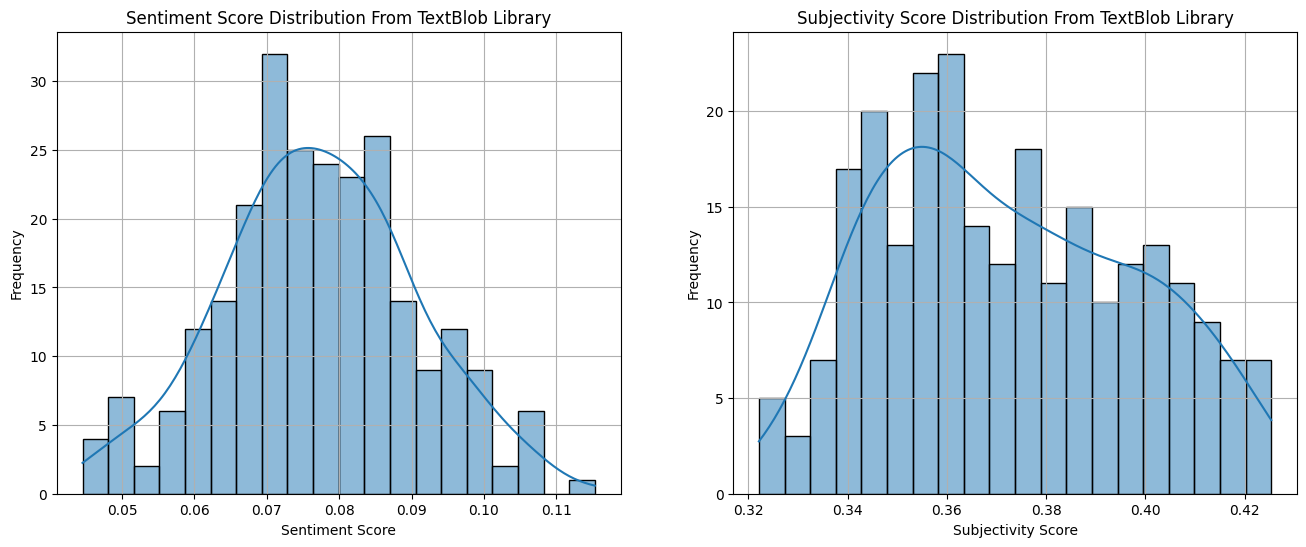

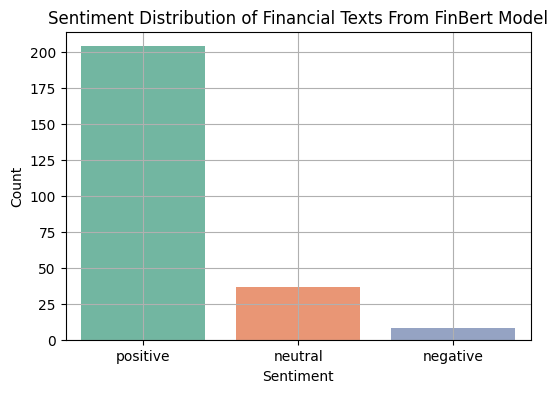

In [13]:
# Sentiment Distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig2, axes2 = plt.subplots(1, 1, figsize=(6, 4))
# Plot histogram of sentiment scores
sns.histplot(merge_df['sentiment'], bins=20, kde=True, ax=axes[0], color='#1f77b4')  # Blue color
axes[0].set_title('Sentiment Score Distribution From TextBlob Library')
axes[0].set_xlabel('Sentiment Score')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

sns.histplot(merge_df['subjectivity'], bins=20, kde=True, ax=axes[1], color='#1f77b4')  # Blue color
axes[1].set_title('Subjectivity Score Distribution From TextBlob Library')
axes[1].set_xlabel('Subjectivity Score')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)

# Plot countplot of sentiment distribution
sns.countplot(x='bert_sentiment', data=merge_df, hue='bert_sentiment', ax=axes2, palette='Set2', legend=False)  # Using seaborn palette 'Set2'
axes2.set_title('Sentiment Distribution of Financial Texts From FinBert Model')
axes2.set_xlabel('Sentiment')
axes2.set_ylabel('Count')
axes2.grid(True)


The first subplot shows the general sentiment scores over time using blue dots. Alongside this, it also displays the Federal Fund Rate over time with red 'x' marks on the same graph, using a separate axis for clarity. This way, you can see how the sentiment and the Federal Fund Rate change together over time.

The second subplot focuses on a more specific type of sentiment analysis using BERT (a machine learning model). This sentiment is shown over time with green dots, allowing you to see how this particular sentiment evolves.

Additionally, the plots are categorized into different time periods based on key events in US history, such as the Dot-com Bust, 9/11 and the wars in Afghanistan and Iraq, the Great Recession, and the Pandemic. Each time period gets its own set of graphs, showing both general sentiment and the BERT sentiment, along with the Federal Fund Rate, so you can compare how these factors interacted during different historical moments.

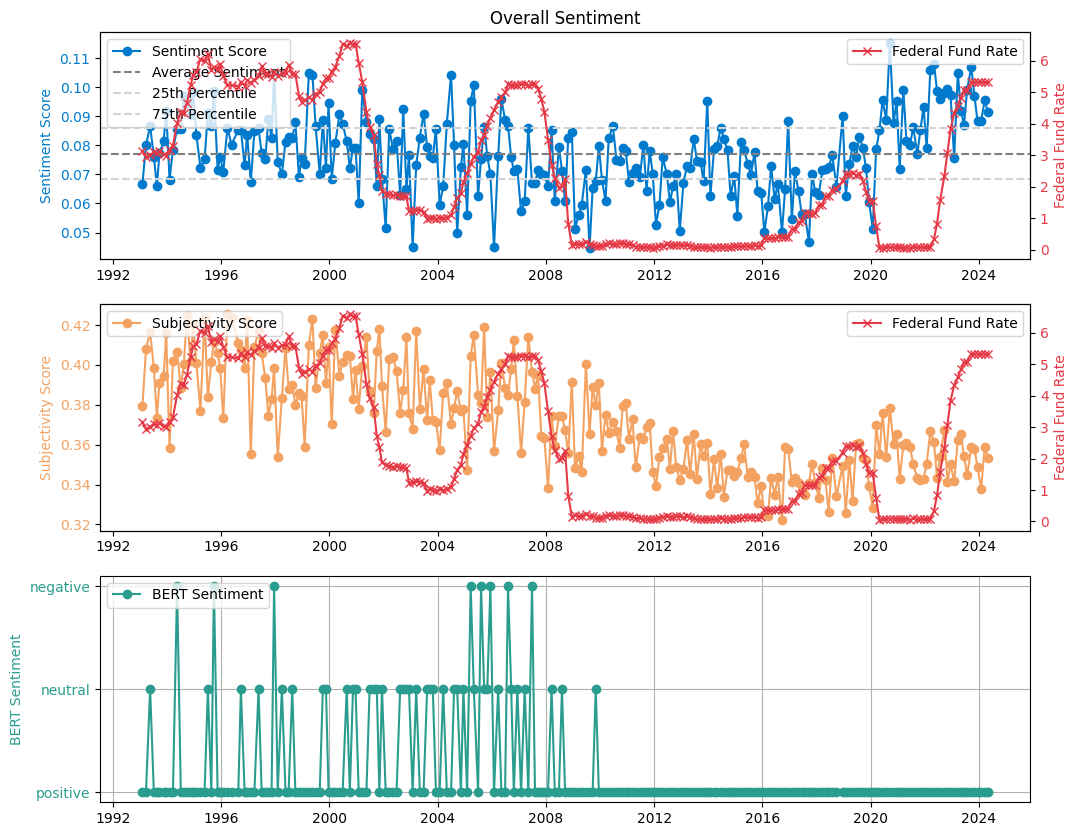

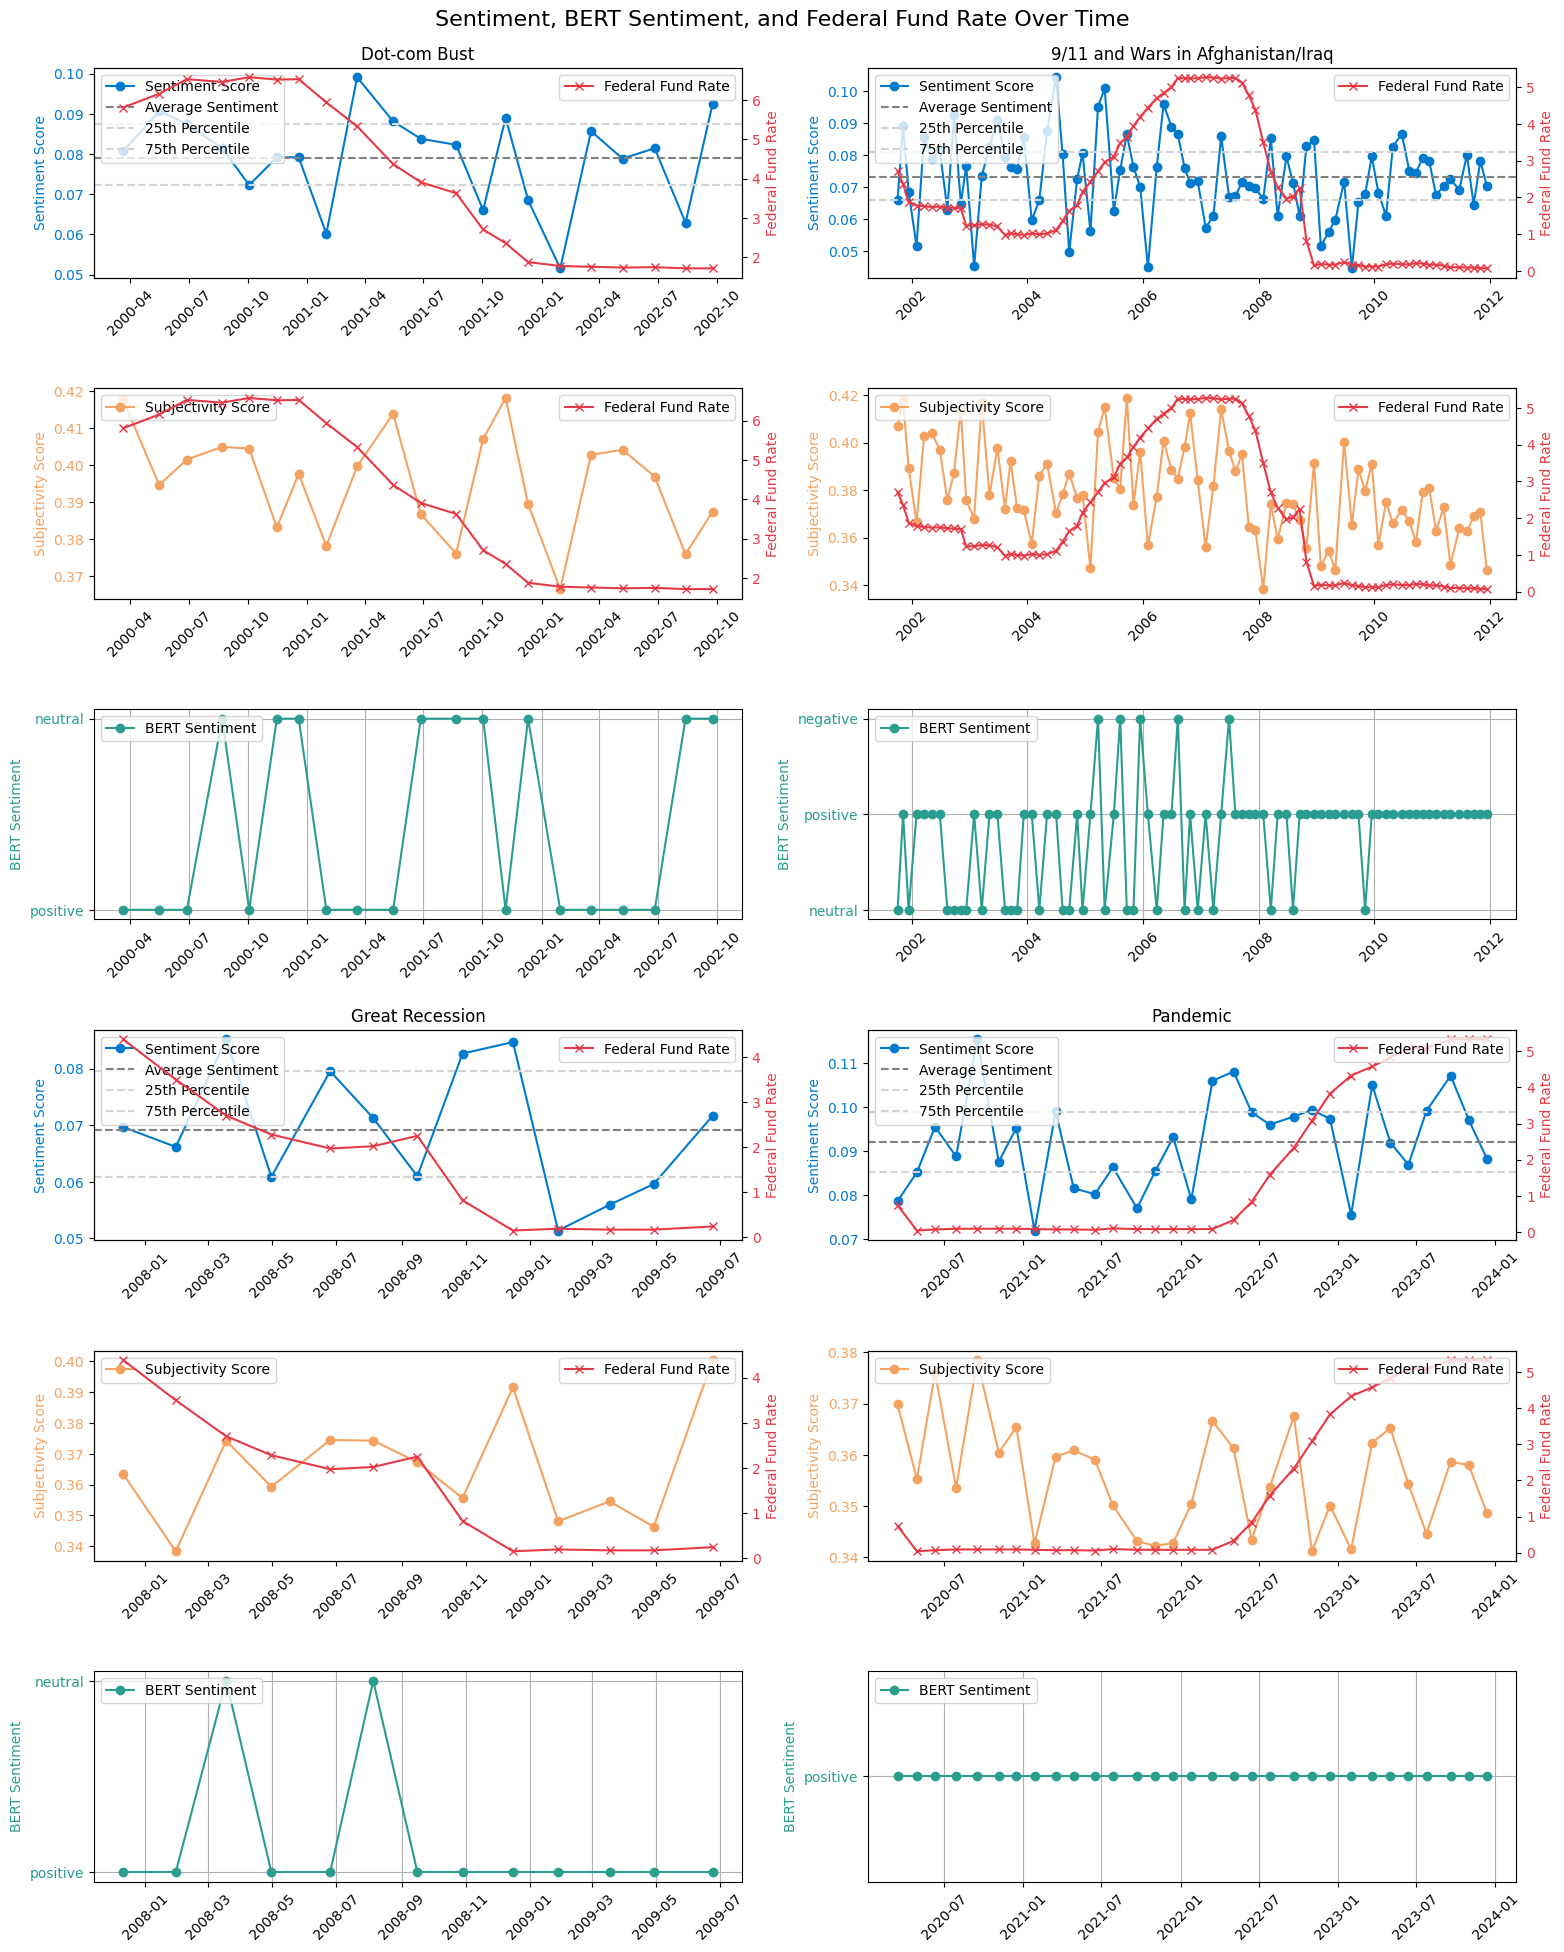

In [14]:
def plot_sentiment(df, title, ax = None, ax3 = None, ax2 = None):
    blue_color = '#007ACC'
    red_color = '#E63946'
    green_color = '#2A9D8F'
    orange_color = '#F4A261'
    avg_sentiment = df['sentiment'].mean()
    q25_sentiment = np.percentile(df['sentiment'], 25)
    q75_sentiment = np.percentile(df['sentiment'], 75)
    
    # Plot sentiment and Federal Fund Rate over time
    ax.plot(df.index, df['sentiment'], color=blue_color, marker='o', label='Sentiment Score')
    ax.axhline(y=avg_sentiment, color='gray', linestyle='--', label='Average Sentiment')
    ax.axhline(y=q25_sentiment, color='lightgray', linestyle='--', label='25th Percentile')
    ax.axhline(y=q75_sentiment, color='lightgray', linestyle='--', label='75th Percentile')
    ax.set_ylabel('Sentiment Score', color=blue_color)
    ax.tick_params(axis='y', labelcolor=blue_color)
    ax.legend(loc='upper left')

    axes_twin = ax.twinx()
    axes_twin.plot(df.index, df['rate'], color=red_color, marker='x', label='Federal Fund Rate')
    axes_twin.set_ylabel('Federal Fund Rate', color=red_color)
    axes_twin.tick_params(axis='y', labelcolor=red_color)
    axes_twin.legend(loc='upper right')
    
    ax3.plot(df.index, df['subjectivity'], color=orange_color, marker='o', label='Subjectivity Score')
    ax3.set_ylabel('Subjectivity Score', color=orange_color)
    ax3.tick_params(axis='y', labelcolor=orange_color)
    ax3.legend(loc='upper left')
        
    axes_twin_2 = ax3.twinx()
    axes_twin_2.plot(df.index, df['rate'], color=red_color, marker='x', label='Federal Fund Rate')
    axes_twin_2.set_ylabel('Federal Fund Rate', color=red_color)
    axes_twin_2.tick_params(axis='y', labelcolor=red_color)
    axes_twin_2.legend(loc='upper right')
    
    # Plot BERT Sentiment over time
    ax2.plot(df.index, df['bert_sentiment'], color=green_color, marker='o', label='BERT Sentiment')
    ax2.set_ylabel('BERT Sentiment', color=green_color)
    ax2.tick_params(axis='y', labelcolor=green_color)
    ax2.grid(True)
    ax2.legend(loc='upper left')
    
    ax.set_title(title)

fig2, axes2 = plt.subplots(3, 1, figsize=(12, 10))
fig, axes = plt.subplots(6, 2, figsize=(16, 20))


plot_sentiment(merge_df, 'Overall Sentiment', axes2[0], axes2[1], axes2[2])

plot_sentiment(dot_com_bust, 'Dot-com Bust',axes[0, 0], axes[1, 0], axes[2, 0])
plot_sentiment(wars_in_afghanistan_iraq, '9/11 and Wars in Afghanistan/Iraq', axes[0, 1], axes[1, 1], axes[2, 1])
plot_sentiment(great_recession, 'Great Recession', axes[3, 0], axes[4, 0], axes[5, 0])
plot_sentiment(pandemic, 'Pandemic', axes[3, 1], axes[4, 1], axes[5, 1])
fig.suptitle('Sentiment, BERT Sentiment, and Federal Fund Rate Over Time', fontsize=16)

for ax in axes.flat:
    if ax is not None:
        ax.tick_params(axis='x', rotation=45)

plt.tight_layout(pad=2.0)
plt.show()

Correlation coefficient between rate and sentiment: 0.27465812715678684


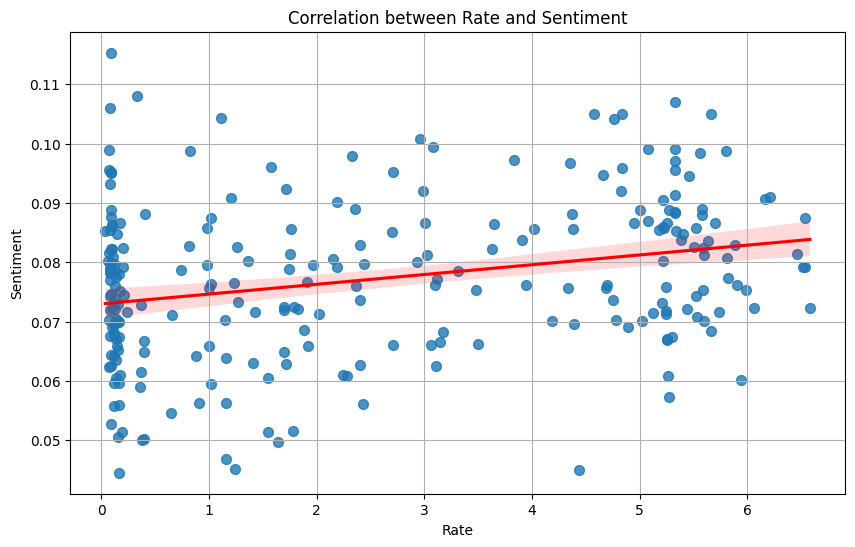

Correlation coefficient between rate and subjectivity: 0.5695087271059517


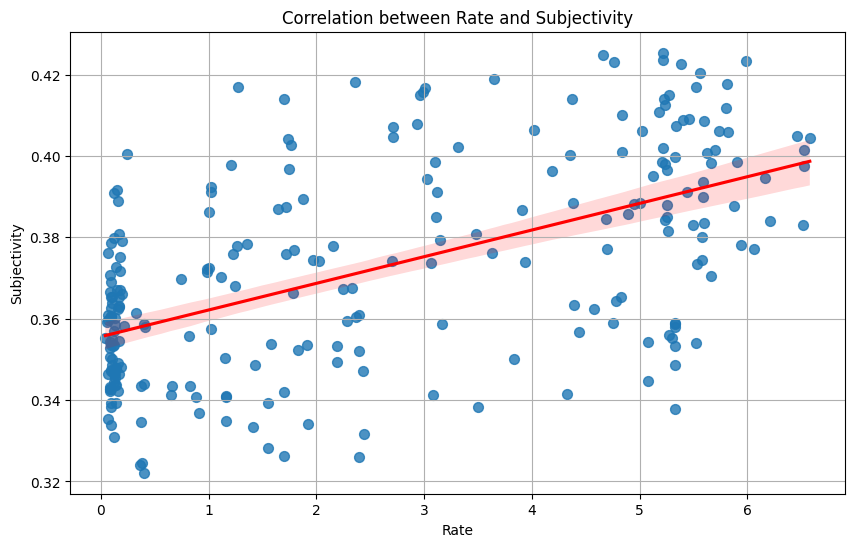

In [15]:
sentiment_correlation = merge_df['rate'].corr(merge_df['sentiment'])
print(f"Correlation coefficient between rate and sentiment: {sentiment_correlation}")

def get_sentiment_corr(df):
    plt.figure(figsize=(10, 6))
    sns.regplot(x='rate', y='sentiment', data=df, scatter_kws={'s': 50}, line_kws={"color": "red"})
    plt.title('Correlation between Rate and Sentiment')
    plt.xlabel('Rate')
    plt.ylabel('Sentiment')
    plt.grid(True)
    plt.show()

get_sentiment_corr(merge_df)

subjectivity_correlation = merge_df['rate'].corr(merge_df['subjectivity'])
print(f"Correlation coefficient between rate and subjectivity: {subjectivity_correlation}")

def get_subjectivity_corr(df):
    plt.figure(figsize=(10, 6))
    sns.regplot(x='rate', y='subjectivity', data=df, scatter_kws={'s': 50}, line_kws={"color": "red"})
    plt.title('Correlation between Rate and Subjectivity')
    plt.xlabel('Rate')
    plt.ylabel('Subjectivity')
    plt.grid(True)
    plt.show()

get_subjectivity_corr(merge_df)

### **2. Key phrase extraction**

The script below uses SpaCy, a library for natural language processing, to find important phrases in meeting minutes. It defines a function that processes a list of texts to identify key phrases, specifically focusing on noun phrases (like "economic growth" or "market trends"). The function ignores common English words and any phrases from a given list of words to exclude, which might not be meaningful in this context.

An exclusion list is created with words and phrases like 'committees', 'participants', and 'economy' that are too general or not useful for the analysis. The function is then applied to the meeting minutes stored in a DataFrame called merge_df. The resulting key phrases for each meeting minute are added as a new column called 'key_phrases'. This helps in highlighting the most relevant and important phrases from the meeting minutes, making it easier to understand the key points discussed.

In [16]:
nlp = spacy.load("en_core_web_sm")

def extract_key_phrases(texts, exclude_strings=None):
    if exclude_strings is None:
        exclude_strings = []
    docs = list(nlp.pipe(texts, batch_size=50))
    key_phrases = []
    for doc in docs:
        phrases = [chunk.text for chunk in doc.noun_chunks if chunk.text.lower() not in stopwords.words('english') and chunk.text.lower() not in exclude_strings]
        key_phrases.append(phrases)
    return key_phrases

exclude_list = ['us', 'committees', 'participants', 'members', 'several participants',
                'committee', 'period', 'term', 'many participants', 'federal reserve banks',
                'federal reserves', 'measures', 'month', 'federal open market committee',
                'member', 'several participant', 'participant', 'many participant',
                'next meeting committee', 'intermeeting period', 'direct federal reserve bank new york',
                'monetary policy', 'office board governor federal reserve system washington dc' ]
merge_df['key_phrases'] = extract_key_phrases(merge_df['meeting_minute'].tolist(), exclude_strings=exclude_list)

dot_com_bust_key_phase = filter_by_time_bracket(merge_df, *time_brackets["Dot-com Bust"])
wars_in_afghanistan_iraq_key_phase = filter_by_time_bracket(merge_df, *time_brackets["9/11 and Wars in Afghanistan/Iraq"])
great_recession_key_phase = filter_by_time_bracket(merge_df, *time_brackets["Great Recession"])
pandemic_key_phase = filter_by_time_bracket(merge_df, *time_brackets["Pandemic"])

In [17]:
#TODO
text = "It shall be the normal practice to arrange with foreign central banks for the coordination of foreign currency transactions. In making operating arrangements with foreign central banks on System holdings of foreign currencies, the Federal Reserve Bank of New York shall not commit itself to maintain any specific balance, unless authorized by the Federal Open Market Committee. Any agreements or understandings concerning the administration of the accounts maintained by the Federal Reserve Bank of New York with the foreign banks designated by the Board of Governors under Section 214.5 of Regulation N shall be referred for review and approval to the Committee."
def run_llama():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_name = "meta-llama/Meta-Llama-3-8B"
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token=True)
    model = AutoModelForCausalLM.from_pretrained(model_name, use_auth_token=True).to(device)
    summarizer = pipeline('text-generation', model=model, tokenizer=tokenizer)
    tokenizer.pad_token_id = tokenizer.eos_token_id 
    def create_prompt(text):
        prompt = f"""
                <s>[INST] <<SYS>>
                You are a financial domian worker. You need to be expert to undesatnd fed meeting minutes.
                <</SYS>>
                Please help to to summarise the following meeting mintues: {text}
                [/INST]>
                """
        return prompt
        
    summary = summarizer(
        create_prompt(text),
        do_sample=True,
        top_k=5,
        max_length=4096,
        return_full_text=False,
        min_length=100,
        truncation=True,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )
    print(summary[0]['generated_text'])
#run_llama()

The visualization tracks how often certain key phrases appear each year in the meeting minutes and then creates a plot to show these trends over time. It first counts the key phrases for each year and stores these counts in a table. Then, it makes a graph with two parts: one showing the top key phrases over the years with lines, and another showing the Federal Fund Rate over time with a red line. The result is a clear visual comparison of key phrase trends and interest rates, helping to see how discussion topics and financial policies evolve together.

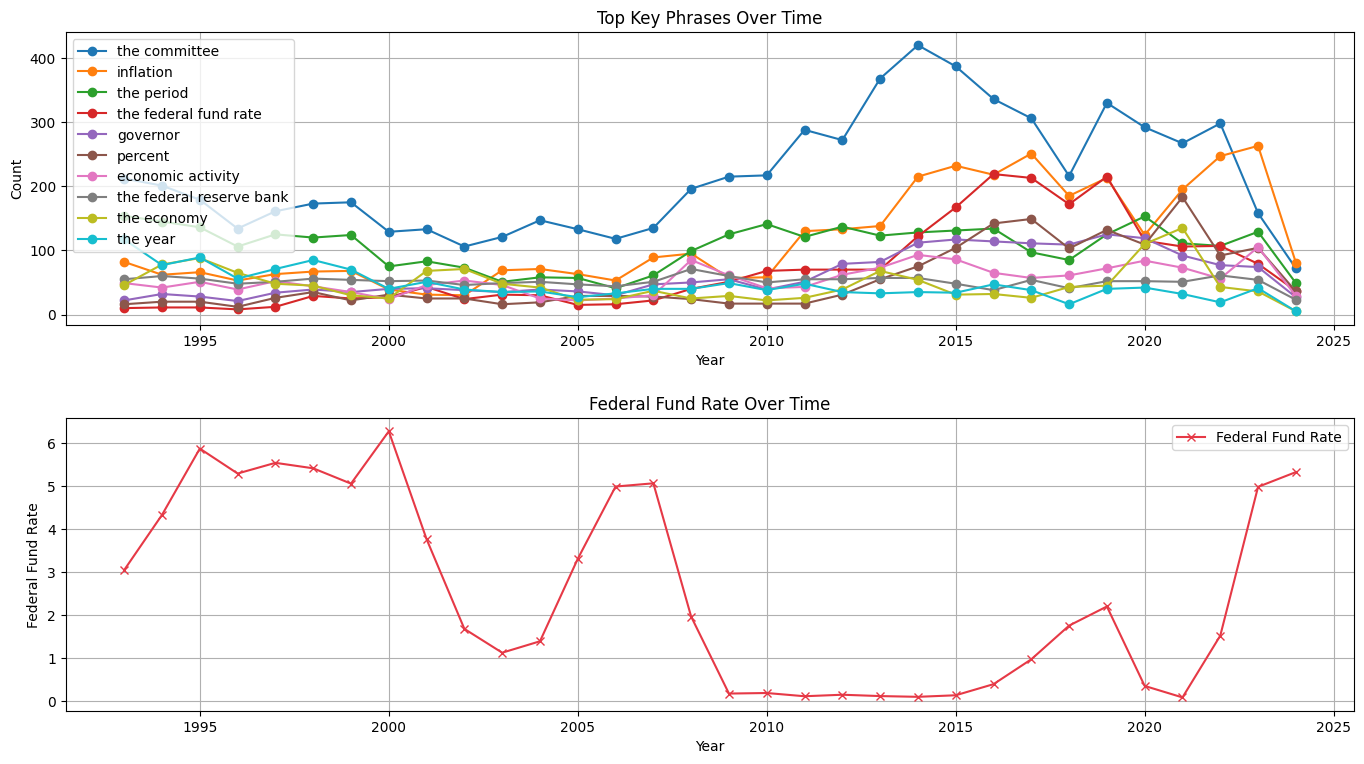

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

# Assuming you have already defined merge_df and imported necessary libraries

# Initialize key phrase counts dictionary
key_phrase_counts = {}

# Count occurrences of key phrases for each year
for date, phrases in zip(merge_df.index, merge_df['key_phrases']):
    year = date.year
    if year not in key_phrase_counts:
        key_phrase_counts[year] = Counter()
    key_phrase_counts[year].update(phrases)

# Convert the dictionary to a DataFrame for plotting
key_phrase_df = pd.DataFrame(key_phrase_counts).T.fillna(0)

# Identify the top key phrases (e.g., top 10)
top_phrases = key_phrase_df.sum().sort_values(ascending=False).head(10).index

red_color = '#E63946'
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot the top key phrases over time
for phrase in top_phrases:
    axes[0].plot(key_phrase_df.index, key_phrase_df[phrase], marker='o', label=phrase)

axes[0].set_title('Top Key Phrases Over Time')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Count')
axes[0].legend()
axes[0].grid(True)

# Aggregate the federal funds rate by year (assuming merge_df has 'rate' column)
annual_fed_rate = merge_df.groupby(merge_df.index.year)['rate'].mean()

# Plot the federal fund rate over time
axes[1].plot(annual_fed_rate.index, annual_fed_rate, color=red_color, marker='x', label='Federal Fund Rate')
axes[1].set_title('Federal Fund Rate Over Time')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Federal Fund Rate')
axes[1].tick_params(axis='y')
axes[1].legend(loc='upper right')
axes[1].grid(True)

plt.tight_layout(pad=2.0)
plt.show()


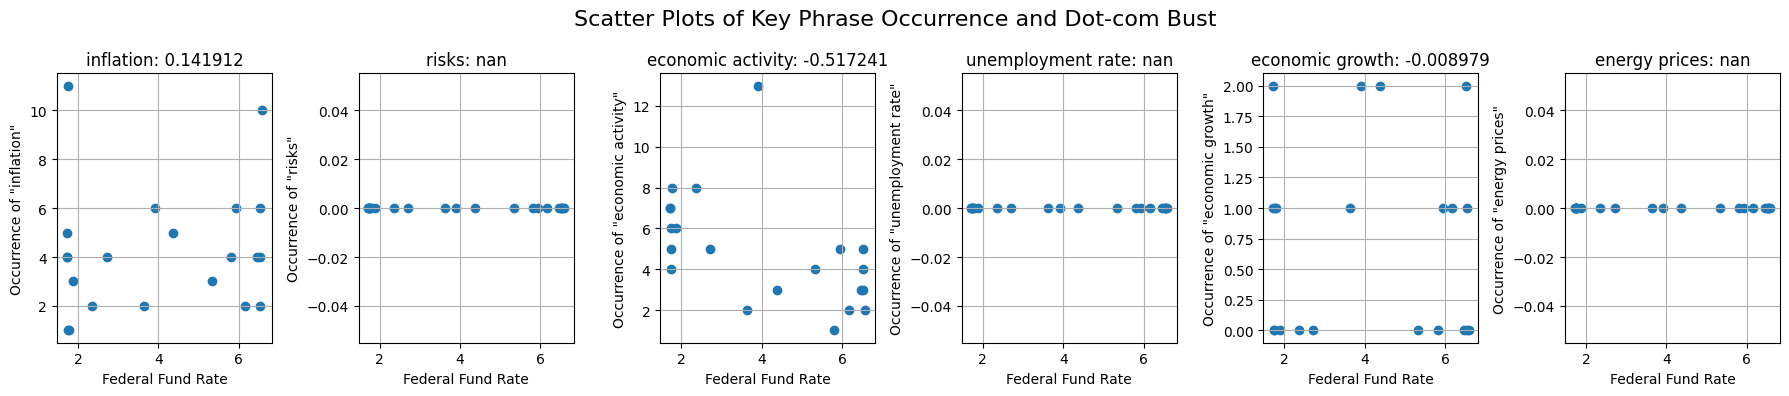

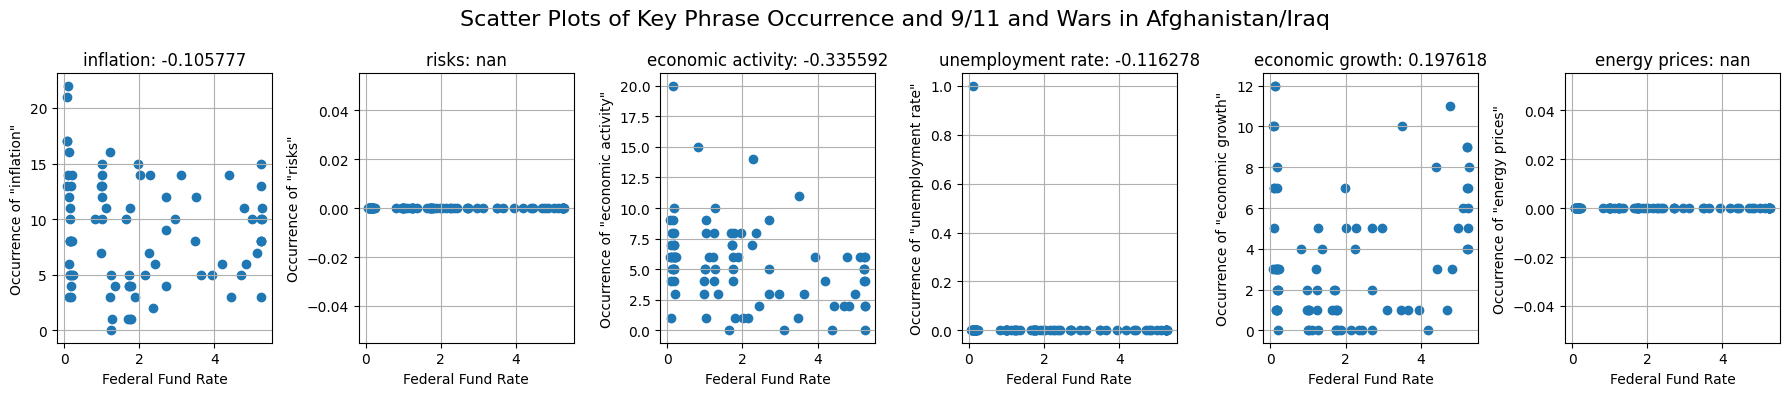

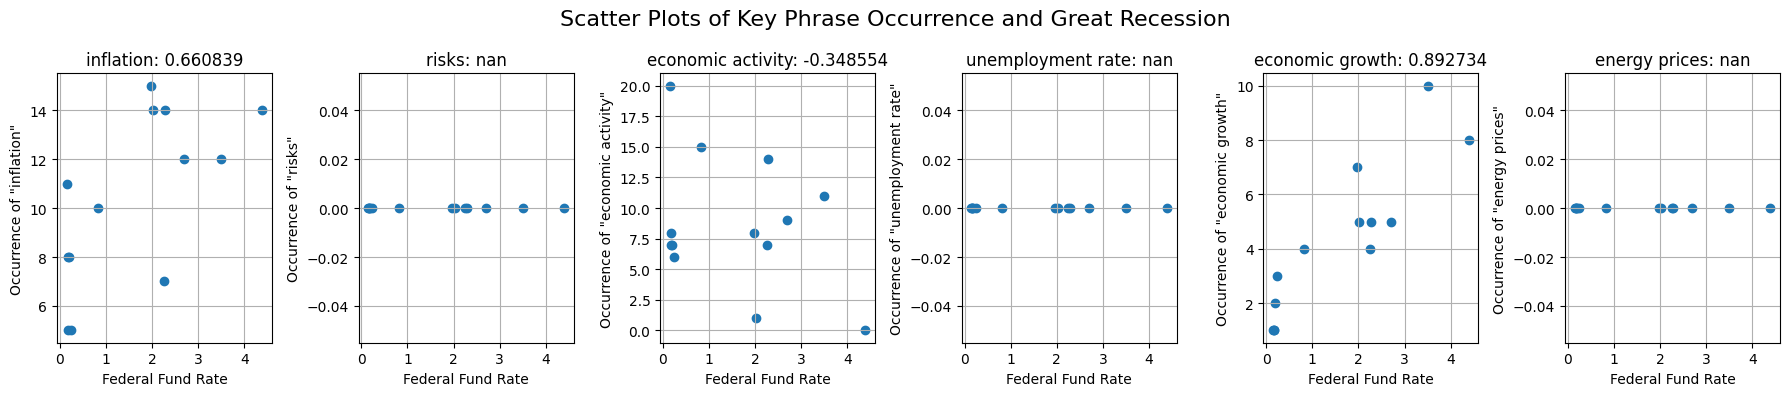

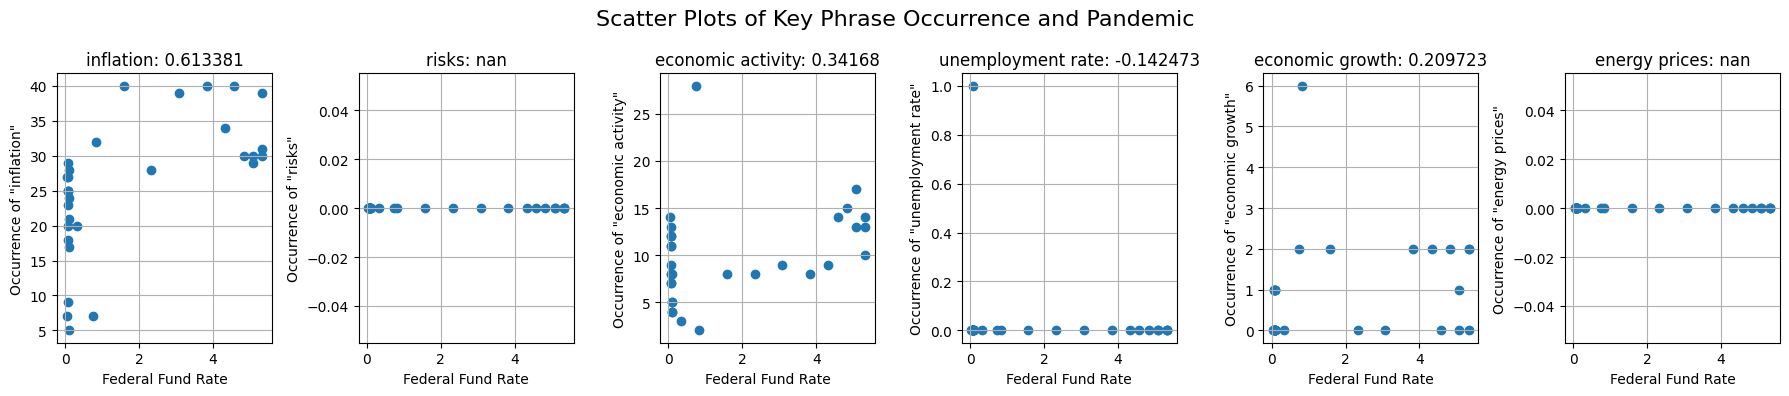

In [19]:
def analyze_all_years(merge_df, texts, topic):
    num_texts = len(texts)
    fig, axes = plt.subplots(1, num_texts, figsize=(3 * num_texts,  4))
    correlations = {}

    for j, text in enumerate(texts):
        correlation = merge_df['rate'].corr(merge_df['key_phrases'].apply(lambda x: x.count(text)))
        correlations[text] = correlation

        # Plot the scatter plot for the text
        ax = axes[j]
        ax.scatter(merge_df['rate'], merge_df['key_phrases'].apply(lambda x: x.count(text)))
        ax.set_title(f'{text}: {round(correlation, 6)}')
        ax.set_xlabel('Federal Fund Rate')
        ax.set_ylabel(f'Occurrence of "{text}"')
        ax.grid(True)

    fig.suptitle(f'Scatter Plots of Key Phrase Occurrence and {topic}', fontsize=16)
    plt.tight_layout()
    plt.show()
    
# Example usage:
texts = ['inflation','risks', 'economic activity', 'unemployment rate', 'economic growth', 'energy prices']

# Example data (replace with your actual DataFrames)
analyze_all_years(dot_com_bust_key_phase, texts, 'Dot-com Bust')
analyze_all_years(wars_in_afghanistan_iraq_key_phase, texts, '9/11 and Wars in Afghanistan/Iraq')
analyze_all_years(great_recession_key_phase, texts, 'Great Recession')
analyze_all_years(pandemic_key_phase, texts, 'Pandemic')

The code reads economic data from a file, processes it to ensure the date information is correct and complete, and then divides this data into segments corresponding to four major historical periods: the Dot-com Bust, the 9/11 and Wars in Afghanistan/Iraq, the Great Recession, and the Pandemic. For each period, it calculates how various economic indicators, such as interest rates, consumer prices, GDP, and unemployment rates, are related to each other. Finally, it creates heatmaps to visually display these relationships, allowing for a clear comparison of how these economic factors interacted during each significant event.

Here are the key words mappings:
rate - Fed Fund Rate<br>

##### **Inflation Related:**
- cpi - Consumer Price Index<br>
- ppi - Producer Price Index<br>
- pce - Personal Consumption Expenditures Price Index<br>

##### **Economic Activity Related:**
- gdp - Gross Domestic Product<br>
- indp - Industrial Production<br>
- tcu - Capacity Utilization<br>

##### **Unemployment Rate Related:**
- unrate - Unemployment Rate<br>

##### **Energy Prices Related:**
- cpieng - Energy Price Index<br>

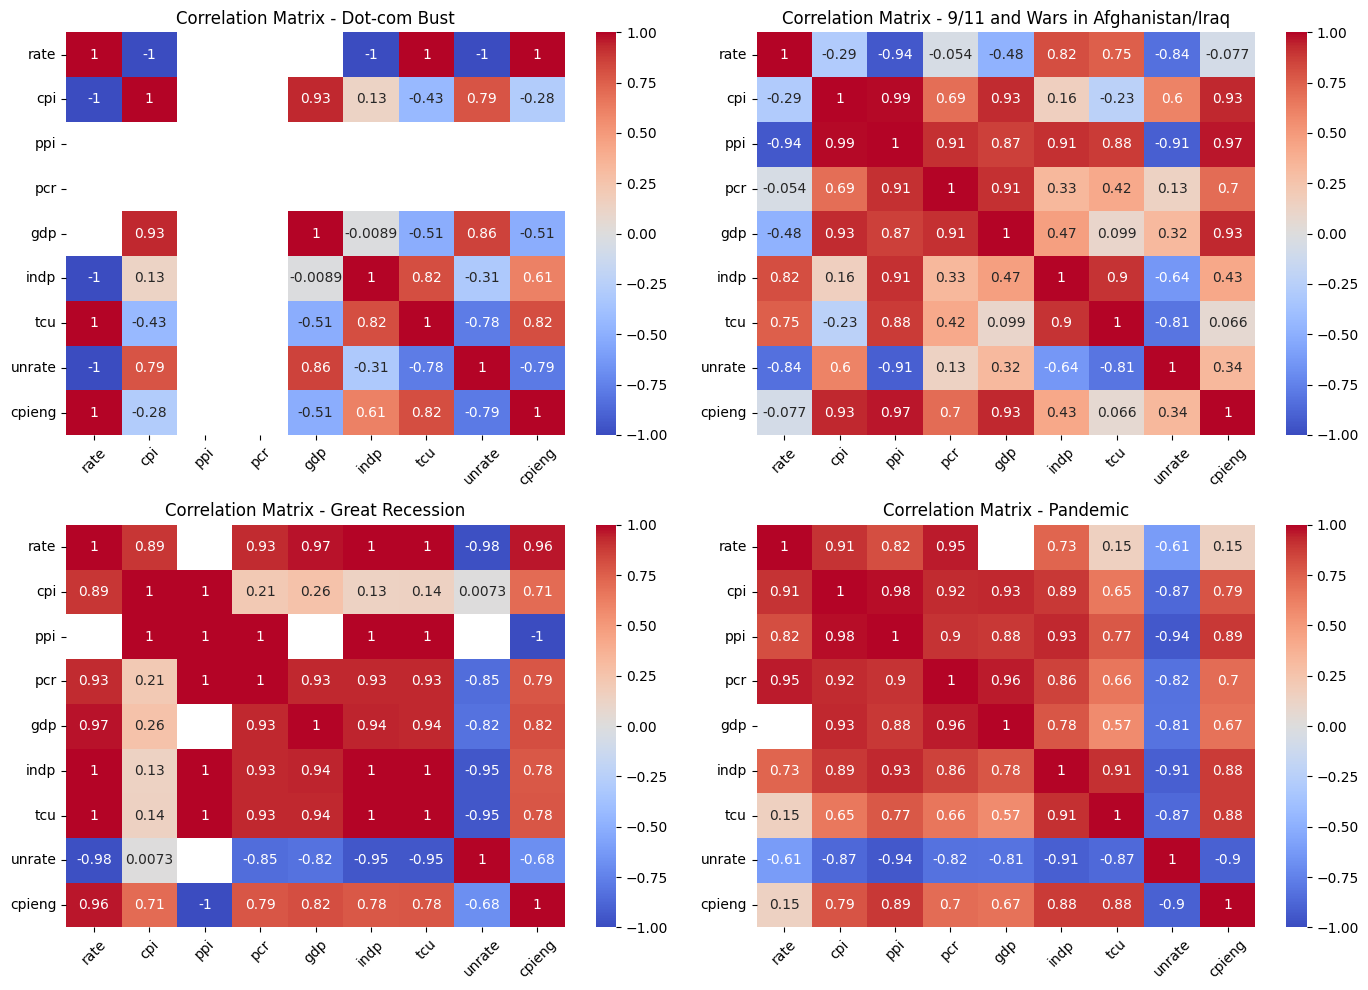

In [20]:
fed_data = pd.read_csv("data/fed_data.csv")
fed_data = pd.DataFrame(fed_data)
fed_data['date'] = pd.to_datetime(fed_data['date'])
fed_data.dropna(subset=['date'], inplace=True)
fed_data = fed_data.set_index('date')

dot_com_bust_fed = filter_by_time_bracket(fed_data, *time_brackets["Dot-com Bust"])
wars_in_afghanistan_iraq_fed = filter_by_time_bracket(fed_data, *time_brackets["9/11 and Wars in Afghanistan/Iraq"])
great_recession_fed = filter_by_time_bracket(fed_data, *time_brackets["Great Recession"])
pandemic_fed = filter_by_time_bracket(fed_data, *time_brackets["Pandemic"])

# Function to calculate correlation between rate and other columns
def calculate_correlation(df):
    return df[['rate', 'cpi', 'ppi', 'pcr', 'gdp', 'indp', 'tcu', 'unrate', 'cpieng']].corr()
    
filtered_dfs = [
    dot_com_bust_fed,
    wars_in_afghanistan_iraq_fed,
    great_recession_fed,
    pandemic_fed
]

correlations = [calculate_correlation(df) for df in filtered_dfs]

time_bracket_names = list(time_brackets.keys())
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

for i, (corr_df, time_bracket_name) in enumerate(zip(correlations, time_bracket_names)):
    ax = axes[i // 2, i % 2]
    sns.heatmap(corr_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=ax)
    ax.set_title(f'Correlation Matrix - {time_bracket_name}')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    

plt.tight_layout()
plt.show()

# **Prepare Training Data**

This code is about preparing data for a machine learning project by splitting it into training and testing sets. It starts by converting the 'meeting_minute' column from a dataframe into strings, which will be used as the input data (X). The 'rate' column is used as the target data (y). The first 80% of the meeting minutes are extracted to be the training data, while the remaining 20% are set aside for testing. Both the training (y_train) and testing (y_test) target variables are reshaped to ensure they have the correct dimensions.

In [21]:

X = merge_df['meeting_minute'].astype(str)
y = merge_df['rate']
print(f'Type of X is {type(X)}')
print(f'Type of y is {type(y)}')

train_size = int(len(X) * 0.8) # 80% Training 20% Test
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

print(f'Shape of Train X and y is {X_train.shape}, {y_train.shape}')
print(f'Shape of Test X and y is {X_test.shape}, {y_test.shape}')

Type of X is <class 'pandas.core.series.Series'>
Type of y is <class 'pandas.core.series.Series'>
Shape of Train X and y is (199,), (199, 1)
Shape of Test X and y is (50,), (50, 1)


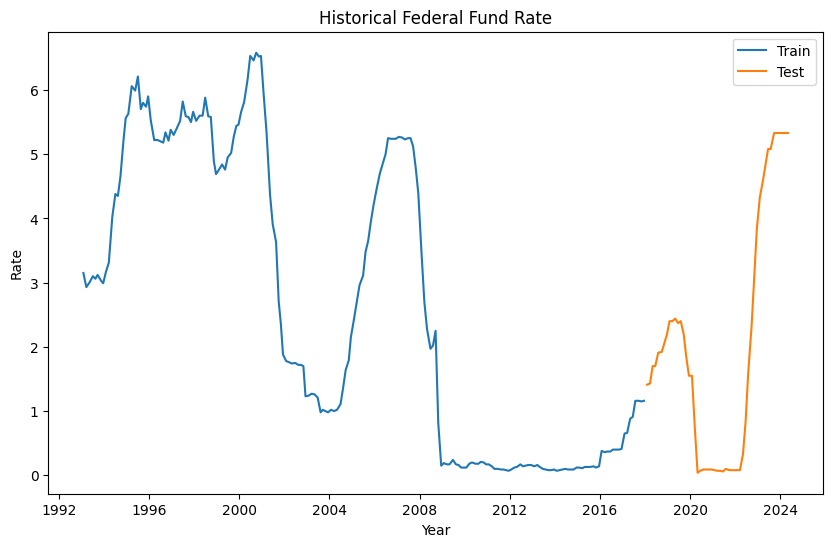

In [22]:
plt.figure(figsize=(10,6))
plt.plot(y.index[:train_size], y_train, label='Train')
plt.plot(y.index[train_size:], y_test, label='Test')
plt.title('Historical Federal Fund Rate')
plt.xlabel('Year')
plt.ylabel('Rate')
plt.legend()

# **D. Supervising Learning** 

### **1. Base Model - Linear Regression**

A basic model using Linear Regression will be trained on the meeting minutes after applying TF-IDF vectorization. This model will serve as a baseline for comparing other models. The only features used for training are the raw text vectorized into numerical format.

In [23]:
results = {}

Means squared error is :4.49491087548249
R2 Score is :-8.62060997852189


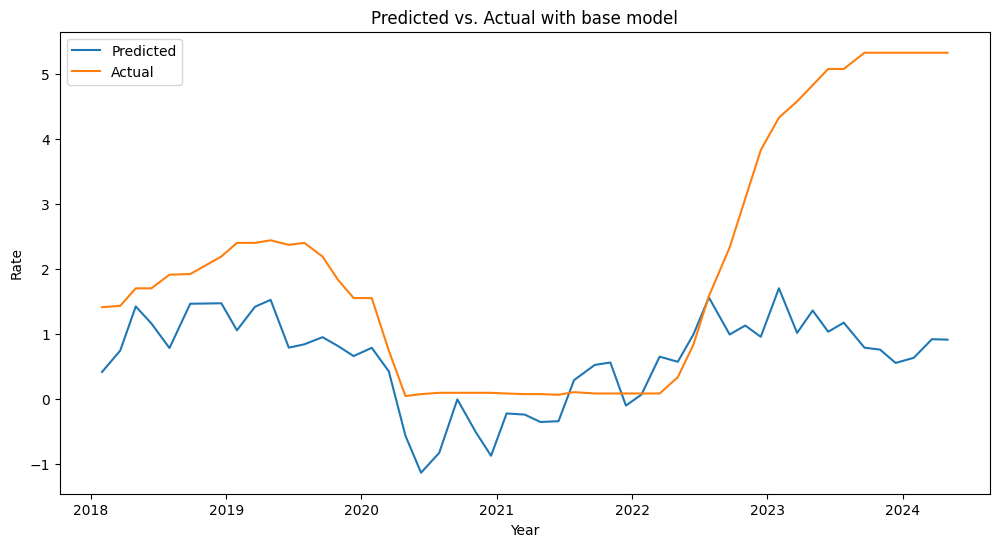

In [24]:

# Perform TF-IDF Vectorizer on the training text corpus
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train.values)
X_test_vectorized = vectorizer.transform(X_test.values)

# Set up model and fit
base_model = LinearRegression()
base_model.fit(X_train_vectorized, y_train)


# Predict, evaluate and plot
y_pred = base_model.predict(X_test_vectorized)
mse = mean_squared_error(y_pred, y_test)
r2 = r2_score(y_pred, y_test)
print(f'Means squared error is :{mse}')
print(f'R2 Score is :{r2}')

# Set up dictionary in results to save information
results['base_model_lr'] = {
    'model': base_model,
    'predicted': y_pred,
    'mse': mse,
    'r2': r2
}
plt.figure(figsize=(12,6))
plt.plot(y.index[train_size:], y_pred, label='Predicted')
plt.plot(y.index[train_size:], y_test, label='Actual')
plt.title('Predicted vs. Actual with base model')
plt.xlabel('Year')
plt.ylabel('Rate')
plt.legend()
plt.show()

### **2. Actual Models - Linear Regression, Support Vector Machine, Decision Tree Regressor and XGBoost Regressor**

The functions below work together to identify and evaluate the best machine learning model for a given task. The configure_model() function sets up four different models (Linear Regression, Support Vector Machine, Decision Tree, and XGBoost) and uses grid search to find the best settings for each. The evaluate_model() function trains each model with the training data, makes predictions on the test data, calculates the accuracy using metrics like Mean Squared Error (MSE) and R² score, and prints the best settings and performance results. The run_supervising_learning() function coordinates these steps, evaluates each model, and creates a visual plot comparing actual values to the predicted values from each model, helping to determine which model performs best.

In [25]:
def configure_model():
    # Perform grid search
    lr_search = GridSearchCV(lr_pipeline, param_grid_lr, scoring='neg_mean_squared_error', cv=5)
    svm_search = GridSearchCV(svm_pipeline, param_grid_svm, scoring='neg_mean_squared_error', cv=5)
    dt_search = GridSearchCV(dt_pipeline, param_grid_dt, scoring='neg_mean_squared_error', cv=5)
    xgb_search = GridSearchCV(xgb_pipeline, param_grid_xgb, scoring='neg_mean_squared_error', cv=5)
    return lr_search, svm_search, dt_search, xgb_search

# Evaluation function
def evaluate_model(search, X_train, X_test, y_train, y_test, model_name):
    search.fit(X_train, y_train)
    predictions = search.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print(f"Best Parameters for {model_name}: {search.best_params_}")
    print(f"Mean Squared Error for {model_name}: {mse}")
    print(f"R^2 Score for {model_name}: {r2}")
    
    # Update results dictionary
    results[model_name] = {
        'model': search.best_estimator_,
        'predicted': predictions,
        'mse': mse,
        'r2': r2
    }
    return predictions
    
def run_supervising_learning(X_train, X_test, y_train, y_test, type = ""):
    
    lr_search, svm_search, dt_search, xgb_search = configure_model()
    
    # Evaluate models
    print("Linear Regression:")
    lr_predictions = evaluate_model(lr_search, X_train, X_test, y_train, y_test, 'lr' + type)
    
    print("\nSupport Vector Machine (SVM):")
    svm_predictions = evaluate_model(svm_search, X_train, X_test, y_train, y_test, 'svm' + type)
    
    print("\nDecision Tree Regressor:")
    dt_predictions = evaluate_model(dt_search, X_train, X_test, y_train, y_test, 'dt' + type)
    
    print("\nXGBoost Regressor:")
    xgb_predictions = evaluate_model(xgb_search, X_train, X_test, y_train, y_test, 'xgb' + type)
    
    
    # Plotting the results
    plt.figure(figsize=(12, 8))
    plt.plot(y.index[train_size:], y_test, label='Actual', linestyle='solid')
    plt.plot(y.index[train_size:], lr_predictions, label='LR Predicted', linestyle='dashed')
    plt.plot(y.index[train_size:], svm_predictions, label='SVM Predicted', linestyle='dashed')
    plt.plot(y.index[train_size:], dt_predictions, label='DT Predicted', linestyle='dashed')
    plt.plot(y.index[train_size:], xgb_predictions, label='XGB Predicted', linestyle='dashed')
    
    plt.legend()
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Samples')
    plt.ylabel('Target')
    plt.show()

Linear Regression:
Best Parameters for lr_basic: {}
Mean Squared Error for lr_basic: 4.315098422549727
R^2 Score for lr_basic: -0.2162027974556544

Support Vector Machine (SVM):
Best Parameters for svm_basic: {'clf__C': 10}
Mean Squared Error for svm_basic: 6.575226237334504
R^2 Score for svm_basic: -0.853215792706032

Decision Tree Regressor:
Best Parameters for dt_basic: {'clf__max_depth': 5}
Mean Squared Error for dt_basic: 2.794369340415472
R^2 Score for dt_basic: 0.21241198319423849

XGBoost Regressor:
Best Parameters for xgb_basic: {'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 200}
Mean Squared Error for xgb_basic: 3.866787069585689
R^2 Score for xgb_basic: -0.08984704187040427


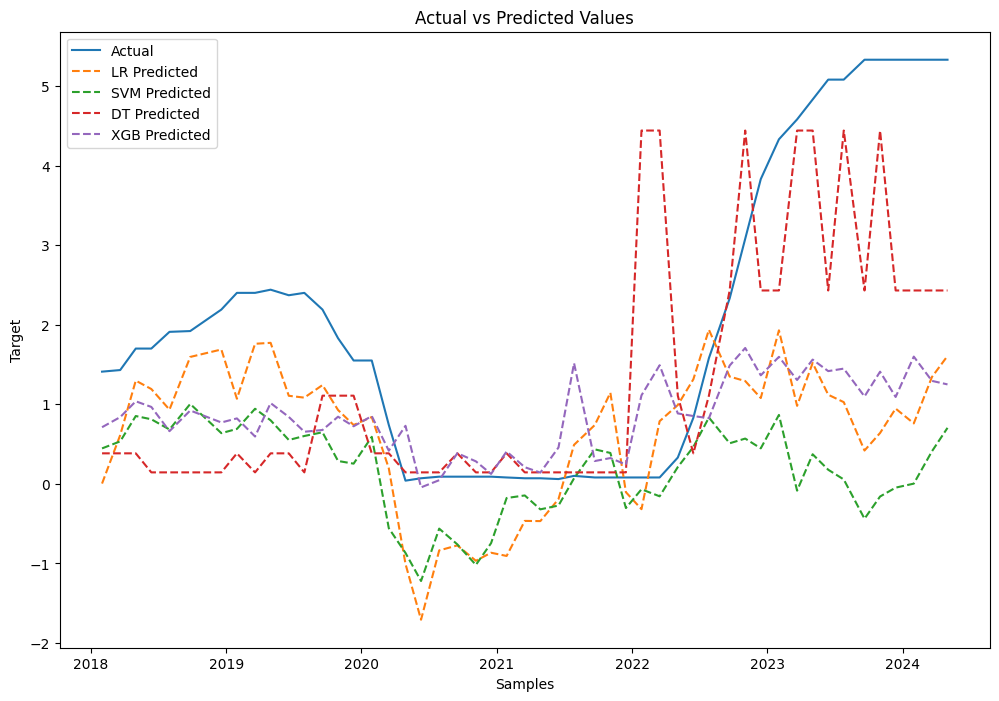

In [26]:
# Define pipelines
lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000)),
    ('svd', TruncatedSVD(n_components=100)),
    ('clf', LinearRegression())
])

svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000)),
    ('svd', TruncatedSVD(n_components=100)),
    ('clf', SVR(kernel='linear'))
])

dt_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000)),
    ('svd', TruncatedSVD(n_components=100)),
    ('clf', DecisionTreeRegressor(random_state=42))
])

xgb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000)),
    ('svd', TruncatedSVD(n_components=100)),
    ('clf', XGBRegressor(objective='reg:squarederror', random_state=42))
])

# Define parameter grids for GridSearchCV
param_grid_lr = {}

param_grid_svm = {
    'clf__C': [0.1, 1, 10]
}
0
param_grid_dt = {
    'clf__max_depth': [5, 10, 20]
}

param_grid_xgb = {
    'clf__n_estimators': [100, 200, 300],
    'clf__learning_rate': [0.01, 0.1, 0.2],
    'clf__max_depth': [3, 5, 7]
}

run_supervising_learning(X_train, X_test, y_train, y_test, "_basic")

### **3. Actual Models With Temporal Features**

The code then creates additional columns to capture trends over time. It does this by looking at how data changes over previous periods, such as one month ago, three months ago, and so on. It also calculates averages and standard deviations over rolling windows of time, like over the past six months or a year.The get_transformed_data function then prepares this data for modeling. It processes text data from the 'meeting_minute' column by converting it into numerical features and reduces its dimensions for simplicity. It also standardizes other numerical features like year, month, day, and the newly created lag and rolling statistics. This makes the data ready for a machine learning model to analyze. The function finally returns the processed training and testing data along with the names of the transformed features.

In [27]:
custom_stop_words = set(stopwords.words('english') + [
    'mr', 'messrs', 'july', 'august', 'april', 'october', 'september', 
    'february', 'december', 'january', 'march', 'november', 'june',
    'participant', 'page', 'noted', 'fourth', 'first', 'second', 'degree', 'shall', 'currency operation',
    'subcommittee', 'arrangement', 'million', 'paragraph', 'authorization'
])

# Function for text preprocessing and apply
def preprocess_text(text):
    text = re.sub(r'\d+', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalpha() and word not in custom_stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)


if 'file_date' not in merge_df.columns:
    merge_df.reset_index(inplace=True)

merge_df['file_date'] = pd.to_datetime(merge_df['file_date'])

merge_df['year'] = merge_df['file_date'].dt.year
merge_df['month'] = merge_df['file_date'].dt.month
merge_df['day'] = merge_df['file_date'].dt.day

lags = [1, 3, 6, 12]
windows = [6, 12, 18, 24]

for lag in lags:
    merge_df[f'rate_{lag}'] = merge_df['rate'].shift(lag)

for window in windows:
    merge_df[f'rate_rolling_mean_{window}'] = merge_df['rate'].rolling(window=window).mean()
    merge_df[f'rate_rolling_std_{window}'] = merge_df['rate'].rolling(window=window).std()

merge_df.fillna(method='bfill', inplace=True)
merge_df.set_index(['file_date'], inplace=True)

merge_df['meeting_minute'] = merge_df['meeting_minute'].apply(preprocess_text)

X_train, y_train = merge_df.drop(columns=['rate'])[:train_size], merge_df['rate'][:train_size]
X_test, y_test = merge_df.drop(columns=['rate'])[train_size:], merge_df['rate'][train_size:]

def get_transformed_data(X_train, X_test):
    text_transformer = Pipeline(steps=[
        ('tfidf', TfidfVectorizer(max_df=0.85, min_df=4, max_features=2000, ngram_range=(1, 2))),
        ('svd', TruncatedSVD(n_components=100))
    ])
    
    # Define temporal features (excluding 'rate')
    temporal_features = ['year', 'month', 'day'] + \
                        [f'rate_{lag}' for lag in lags] + \
                        [f'rate_rolling_mean_{window}' for window in windows] + \
                        [f'rate_rolling_std_{window}' for window in windows]
    
    # Define the preprocessor for both text and temporal features
    preprocessor = ColumnTransformer(
        transformers=[
            ('meeting_minute', text_transformer, 'meeting_minute'),
            ('temporal', StandardScaler(), temporal_features)
        ])
    
    return preprocessor.fit_transform(X_train), preprocessor.transform(X_test), temporal_features

In [28]:
def plot_top_feature():
    # Function to get top N feature importances
    def get_top_feature_importance(model, feature_names, top_n=5):
        if hasattr(model, 'coef_'):
            importance = model.coef_
        elif hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_
        else:
            print(f"No feature importance attribute for {model}")
            return pd.Series()
        
        feature_importance = pd.Series(importance, index=feature_names)
        top_features = feature_importance.sort_values(ascending=False).head(top_n)
        return top_features
    
    # Get feature names from the preprocessor
    text_feature_names = [f'svd_component_{i}' for i in range(100)]  # SVD components
    temporal_feature_names = temporal_features
    all_feature_names = np.concatenate((text_feature_names, temporal_feature_names))
    
    # Extract top 5 features for each model
    lr_top_features = get_top_feature_importance(results['lr']['model'].named_steps['clf'], all_feature_names, top_n=5)
    dt_top_features = get_top_feature_importance(results['dt']['model'].named_steps['clf'], all_feature_names, top_n=5)
    xgb_top_features = get_top_feature_importance(results['xgb']['model'].named_steps['clf'], all_feature_names, top_n=5)
    
    # If you need to plot top 5 for SVM, although it does not provide feature importances directly:
    def get_top_svm_coefficients(model, feature_names, top_n=5):
        if hasattr(model, 'coef_'):
            importance = model.coef_.flatten()
        else:
            print(f"No coefficients attribute for {model}")
            return pd.Series()
        
        feature_importance = pd.Series(importance, index=feature_names)
        top_features = feature_importance.sort_values(ascending=False).head(top_n)
        return top_features
    
    svm_top_features = get_top_svm_coefficients(results['svm']['model'].named_steps['clf'], all_feature_names, top_n=5)
    
    # Set a color palette
    palette = sns.color_palette("Set2", 4)
    
    # Plotting the top 5 feature importances for each model in a single figure with 4 subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Linear Regression
    lr_top_features.plot(kind='barh', ax=axes[0, 0], color=palette[0], edgecolor='black')
    axes[0, 0].set_title('Top 5 Features for Linear Regression')
    axes[0, 0].set_xlabel('Importance')
    axes[0, 0].invert_yaxis()
    
    # Decision Tree
    dt_top_features.plot(kind='barh', ax=axes[0, 1], color=palette[1], edgecolor='black')
    axes[0, 1].set_title('Top 5 Features for Decision Tree')
    axes[0, 1].set_xlabel('Importance')
    axes[0, 1].invert_yaxis()
    
    # XGBoost
    xgb_top_features.plot(kind='barh', ax=axes[1, 0], color=palette[2], edgecolor='black')
    axes[1, 0].set_title('Top 5 Features for XGBoost')
    axes[1, 0].set_xlabel('Importance')
    axes[1, 0].invert_yaxis()
    
    # SVM
    svm_top_features.plot(kind='barh', ax=axes[1, 1], color=palette[3], edgecolor='black')
    axes[1, 1].set_title('Top 5 Features for SVM')
    axes[1, 1].set_xlabel('Importance')
    axes[1, 1].invert_yaxis()
    
    plt.tight_layout()
    plt.show()


Linear Regression:
Best Parameters for lr: {}
Mean Squared Error for lr: 0.27108602972732576
R^2 Score for lr: 0.9235948858124288

Support Vector Machine (SVM):
Best Parameters for svm: {'clf__C': 1}
Mean Squared Error for svm: 0.1180117107967889
R^2 Score for svm: 0.966738609702725

Decision Tree Regressor:
Best Parameters for dt: {'clf__max_depth': 10}
Mean Squared Error for dt: 0.22365348000000002
R^2 Score for dt: 0.936963665390518

XGBoost Regressor:
Best Parameters for xgb: {'clf__max_depth': 3, 'clf__n_estimators': 300}
Mean Squared Error for xgb: 0.20734465777228095
R^2 Score for xgb: 0.9415602778600984


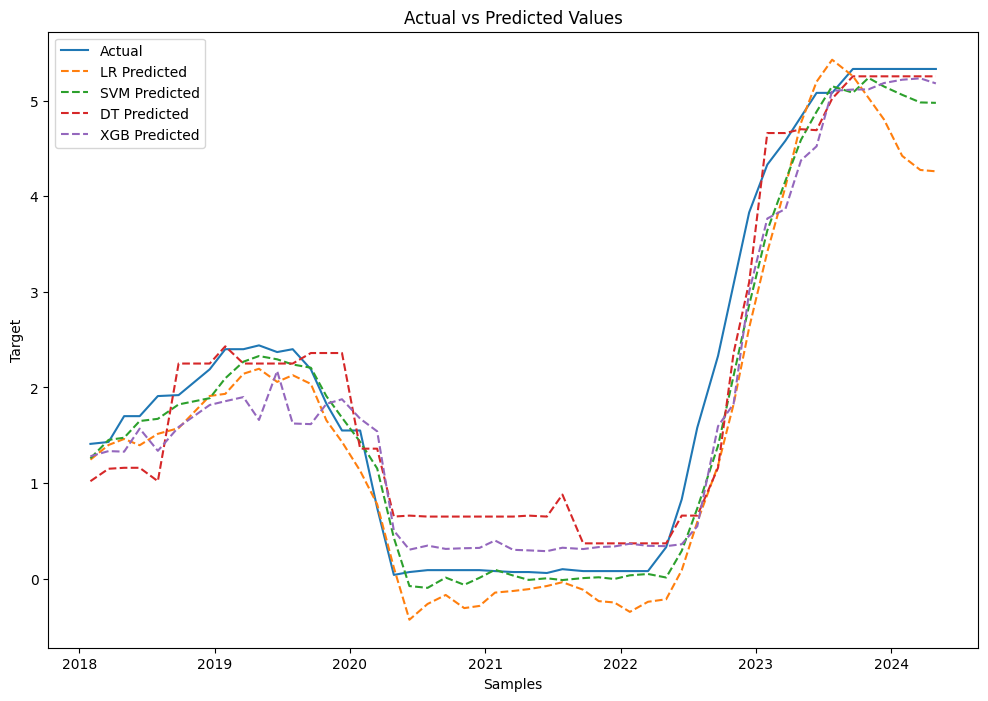

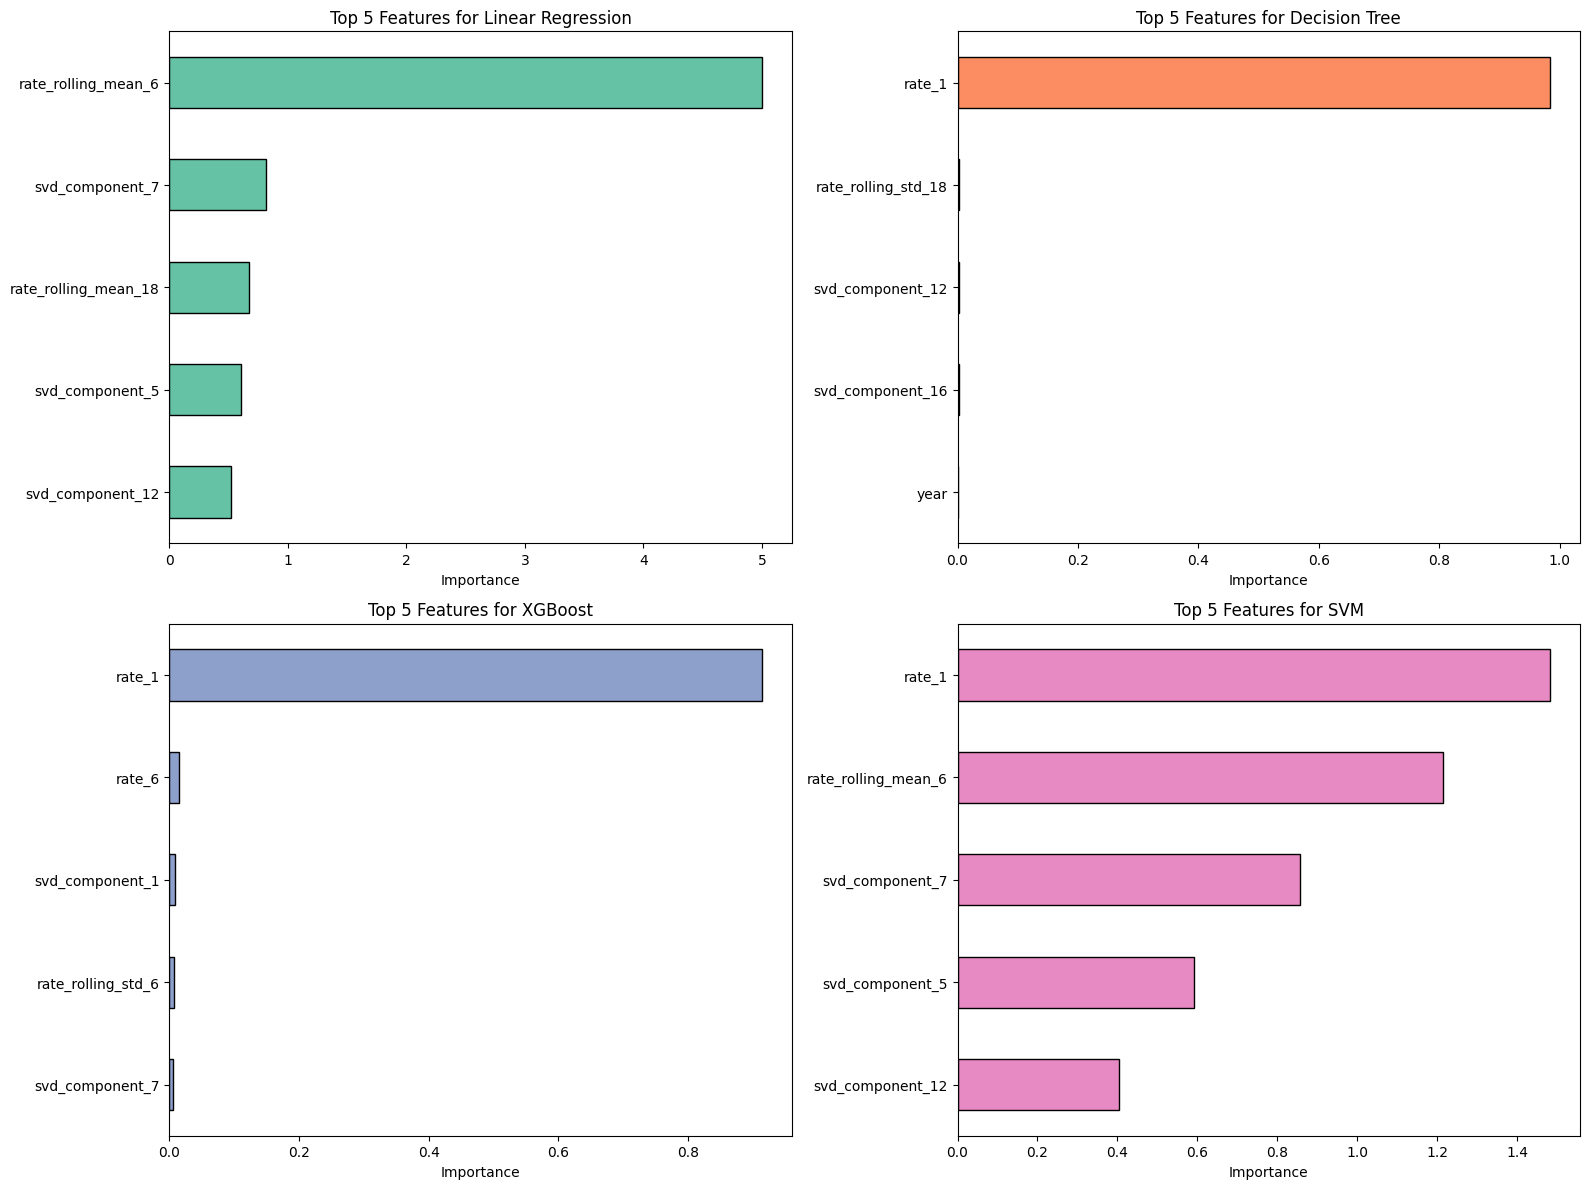

In [29]:
X_train_transformed, X_test_transformed, temporal_features= get_transformed_data(X_train, X_test)

# Define pipelines for each model
lr_pipeline = Pipeline([
    ('clf', LinearRegression())
])

svm_pipeline = Pipeline([
    ('clf', SVR(kernel='linear'))
])

dt_pipeline = Pipeline([
    ('clf', DecisionTreeRegressor(random_state=42))
])

xgb_pipeline = Pipeline([
    ('clf', XGBRegressor(random_state=42))
])

# Define parameter grids for GridSearchCV
param_grid_lr = {}

param_grid_svm = {
    'clf__C': [0.1, 1, 10]
}

param_grid_dt = {
    'clf__max_depth': [5, 10, 20]
}

param_grid_xgb = {
    'clf__n_estimators': [300],
    'clf__max_depth': [3, 5, 7]
}

run_supervising_learning(X_train_transformed, X_test_transformed, y_train, y_test)
plot_top_feature()

### **4. Actual Models With Sentiment Analysis**
This code sets up a tool to analyze the sentiment of text data using a pre-trained model, determining whether the text is positive or negative. It defines a function analyze_sentiment that processes up to 512 characters of text, returning a positive score for positive sentiment and a negative score for negative sentiment. The function is applied to the 'meeting_minute' column in both the training and testing datasets (X_train and X_test), creating a new column called 'raw_sentiment_score' that contains these sentiment scores. This adds a numerical representation of sentiment to each piece of text, which can be used for further analysis or machine learning tasks.

In [30]:
sentiment_analysis = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
def analyze_sentiment(text):
    result = sentiment_analysis(text[:512])[0]  # Truncate to 512 characters
    score = result['score'] if result['label'] == 'POSITIVE' else -result['score']
    return score

X_train['raw_sentiment_score'] = X_train['meeting_minute'].apply(analyze_sentiment)
X_test['raw_sentiment_score'] = X_test['meeting_minute'].apply(analyze_sentiment)

Linear Regression:
Best Parameters for lr: {}
Mean Squared Error for lr: 0.23759326668540878
R^2 Score for lr: 0.9330347613650308

Support Vector Machine (SVM):
Best Parameters for svm: {'clf__C': 1}
Mean Squared Error for svm: 0.12290204115672841
R^2 Score for svm: 0.9653602788092371

Decision Tree Regressor:
Best Parameters for dt: {'clf__max_depth': 10}
Mean Squared Error for dt: 0.16937313580246915
R^2 Score for dt: 0.9522624836318144

XGBoost Regressor:
Best Parameters for xgb: {'clf__max_depth': 3, 'clf__n_estimators': 300}
Mean Squared Error for xgb: 0.21239718640859567
R^2 Score for xgb: 0.9401362316715808


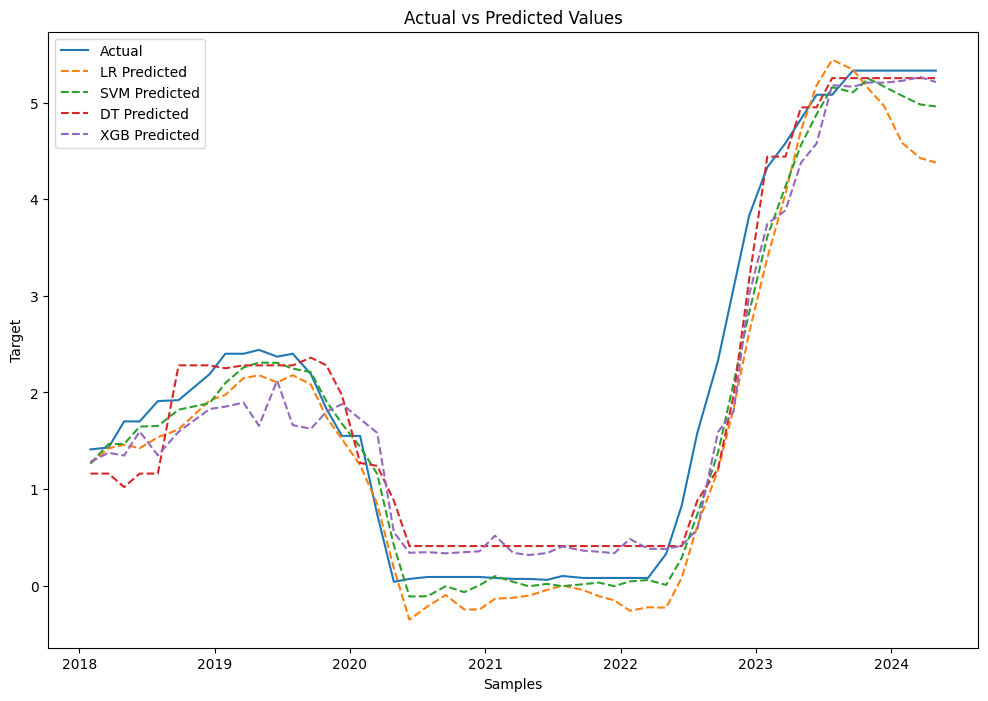

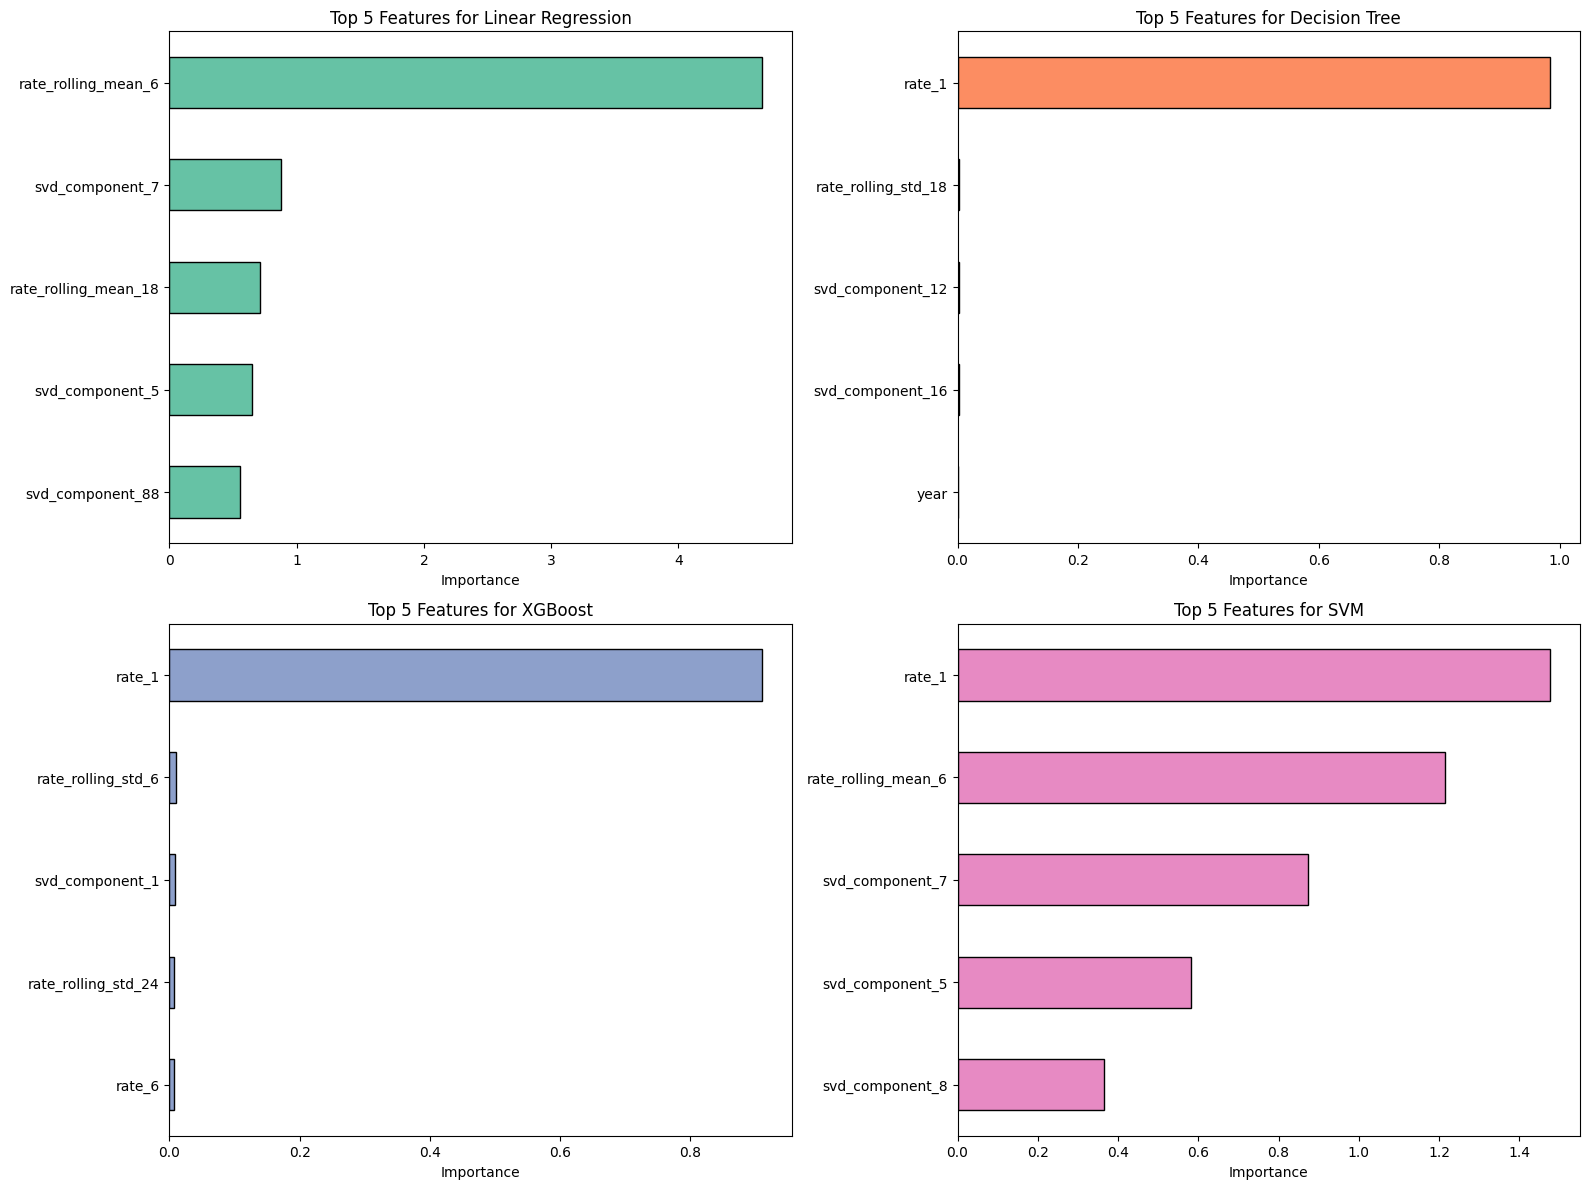

In [31]:
X_train_transformed, X_test_transformed, temporal_features = get_transformed_data(X_train, X_test)

lr_pipeline = Pipeline([
    ('clf', LinearRegression())
])

svm_pipeline = Pipeline([
    ('clf', SVR(kernel='linear'))
])

dt_pipeline = Pipeline([
    ('clf', DecisionTreeRegressor(random_state=42))
])

xgb_pipeline = Pipeline([
    ('clf', XGBRegressor(random_state=42))
])

# Define parameter grids for GridSearchCV
param_grid_lr = {}

param_grid_svm = {
    'clf__C': [0.1, 1, 10]
}

param_grid_dt = {
    'clf__max_depth': [5, 10, 20]
}

param_grid_xgb = {
    'clf__n_estimators': [300],
    'clf__max_depth': [3, 5, 7]
}
run_supervising_learning(X_train_transformed, X_test_transformed, y_train, y_test)
plot_top_feature()

# **E. Unsupervising Learning**

### **1. KMeans Clustering**

In [32]:
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X_train['meeting_minute'])

In [33]:

# K-Means Clustering
num_clusters = 5
km = KMeans(n_clusters=num_clusters, random_state=42)
km.fit(X_tfidf)
clusters = km.labels_

# Add to X_train and X_test
X_train['cluster'] = clusters

# Transform X_test using the same vectorizer 
X_tfidf_test = vectorizer.transform(X_test['meeting_minute'])
clusters_test = km.predict(X_tfidf_test)
X_test['cluster'] = clusters_test


# Get the top words for each topic
def get_top_terms_per_cluster(tfidf_matrix, clusters, vectorizer, top_n=15):
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names_out()
    top_terms = {}
    
    for i in range(num_clusters):
        top_terms[i] = [terms[ind] for ind in order_centroids[i, :top_n]]
    
    return top_terms

# Display top words for each cluster
top_terms = get_top_terms_per_cluster(X_tfidf, clusters, vectorizer, top_n=10)
for cluster, terms in top_terms.items():
    print(f"Cluster {cluster}: {', '.join(terms)}")

Cluster 0: price, wa, inflation, market, growth, committee, quarter, federal, rate, meeting
Cluster 1: federal, market, committee, rate, inflation, policy, financial, economic, reserve, wa
Cluster 2: wa, market, committee, growth, price, rate, member, economic, would, federal
Cluster 3: committee, market, federal, bank, foreign, reserve, wa, currency, open, rate
Cluster 4: market, wa, federal, committee, price, economic, inflation, rate, bank, financial


### **2. LDA Topic grouping**

In [34]:
# Apply LDA 
num_topics = 10
lda = LatentDirichletAllocation(n_components=num_topics, max_iter=10, learning_method='online', learning_decay=0.7, random_state=42)
lda.fit(X_tfidf)

# Get the top words for each topic
def get_top_words(model, feature_names, n_top_words):
    top_words = {}
    for topic_idx, topic in enumerate(model.components_):
        top_words[topic_idx] = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    return top_words

# Display top words for each topic
feature_names = vectorizer.get_feature_names_out()
top_words = get_top_words(lda, feature_names, 10)
for topic, words in top_words.items():
    print(f"Topic {topic}: {', '.join(words)}")

# Convert data 
text_data = [text.split() for text in X_train['meeting_minute']]
id2word = corpora.Dictionary(text_data)
corpus = [id2word.doc2bow(text) for text in text_data]

# Evaluate Coherence
gensim_lda = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=42, passes=10, alpha='auto', per_word_topics=True)
coherence_model_lda = CoherenceModel(model=gensim_lda, texts=text_data, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'Coherence Score: {coherence_lda}')


# Add to train and test dfs
# Transform train data
topics_train = lda.transform(X_tfidf)

# Transform test data
X_tfidf_test = vectorizer.transform(X_test['meeting_minute'])
topics_test = lda.transform(X_tfidf_test)

for i in range(num_topics):
    X_train[f'topic_{i}'] = topics_train[:, i]
    X_test[f'topic_{i}'] = topics_test[:, i]

Topic 0: committee, market, economic, wa, growth, rate, federal, price, year, would
Topic 1: market, committee, federal, wa, rate, inflation, economic, price, policy, reserve
Topic 2: market, wa, committee, federal, quarter, would, price, inflation, growth, member
Topic 3: unacceptable, dropoff, stiffer, augur, sequester, initiative, contemplating, phrase, innovative, giving
Topic 4: committee, wa, price, rate, growth, federal, economic, member, market, principal
Topic 5: market, committee, rate, price, wa, growth, gain, inflation, federal, reserve
Topic 6: market, wa, would, growth, price, historical, urgency, communicating, member, damaged
Topic 7: wa, growth, market, committee, price, inflation, would, meeting, period, rate
Topic 8: wa, market, committee, growth, reserve, price, rate, meeting, quarter, recent
Topic 9: wa, committee, market, business, price, rate, federal, economic, inflation, would
Coherence Score: 0.3258281058960071
